In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(scales)
library(NICHES)
library(stringr)
library(reshape2)
library(cowplot)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
options(warn=-1)
set.seed(42)

In [3]:
female_8weeks_rds <- readRDS('../combined_female_8weeks.rds')

In [4]:
Idents(female_8weeks_rds) <- female_8weeks_rds@meta.data$celltype_broad

In [5]:
female_8weeks_rds

An object of class Seurat 
20743 features across 15465 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [6]:
#write.csv(male_8weeks_rds@meta.data[c('sample_type', 'celltype_broad')],'adjacency_metadata.csv')

In [7]:
data.list <- SplitObject(female_8weeks_rds, split.by="sample_type")

In [8]:
data.list <- lapply(X = data.list, FUN = function(x) {
    x <- NormalizeData(x)
})

Normalizing layer: counts

Normalizing layer: counts



In [9]:
data.list[1]
data.list[2]

$taPVAT_Control_8W_F
An object of class Seurat 
20743 features across 6314 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


$taPVAT_HF_8W_F
An object of class Seurat 
20743 features across 9151 samples within 1 assay 
Active assay: RNA (20743 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap


In [10]:
table(data.list[[1]]@meta.data['celltype_broad'])
table(data.list[[2]]@meta.data['celltype_broad'])

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             3789               710               798               491 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              321                14               180                11 

celltype_broad
       Adipocytes Endothelial_Cells       Fibroblasts      Immune_Cells 
             6075               967               976               529 
Mesothelial_Cells    Neuronal_Cells         Pericytes              SMCs 
              375                 7               211                11 

In [11]:
#for (i in 1:length(data.list)){
  #Idents(data.list[[i]]) <- data.list[[i]]$sample_type
  #data.list[[i]] <- subset(data.list[[i]],cells = WhichCells(data.list[[i]],downsample = max.cells))
#  Idents(data.list[[i]]) <- data.list[[i]]$celltype_broad
#}

In [12]:
# Run NICHES on each system and store/name the outputs
scc.list <- list()
for(i in 1:length(data.list)){
  print(i)
  scc.list[[i]] <- RunNICHES(data.list[[i]],
                             LR.database="fantom5",
                             species="mouse",
                             assay="RNA",
                             cell_types = "celltype_broad",
                             min.cells.per.ident=1,
                             min.cells.per.gene = 50,
                             meta.data.to.map = c('orig.ident','celltype_broad','sample_type'),
                             SystemToCell = T,
                             CellToCell = T,
                            #CellToNeighborhood = T,
                            #NeighborhoodToCell = T
                            )
}

names(scc.list) <- names(data.list)

[1] 1


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 6314 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 721 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 18386 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 6314 System-To-Cell edges were computed, across 8 cell types



[1] 2


Set cell types as Identity of object internally


 Subsetting to populations with greater than 1 cells


 Subsetting to genes expressed in greater than 50 cells


 9151 distinct cells from 8 celltypes to be analyzed


 Limiting ground truth to genes within dataset


 Mapping against 755 ground truth signaling mechanisms


 For sampling purposes, please make sure that the active Identity of the input seurat object corresponds to cell types

Normalizing layer: counts


 23485 Cell-To-Cell edges computed, sampling 64 distinct VectorTypes, out of 64 total possible

Normalizing layer: counts


 9151 System-To-Cell edges were computed, across 8 cell types



In [13]:
temp.list <- list()
for(i in 1:length(scc.list)){
temp.list[[i]] <- scc.list[[i]]$CellToCell 
temp.list[[i]]$Condition <- names(scc.list)[i] 
}

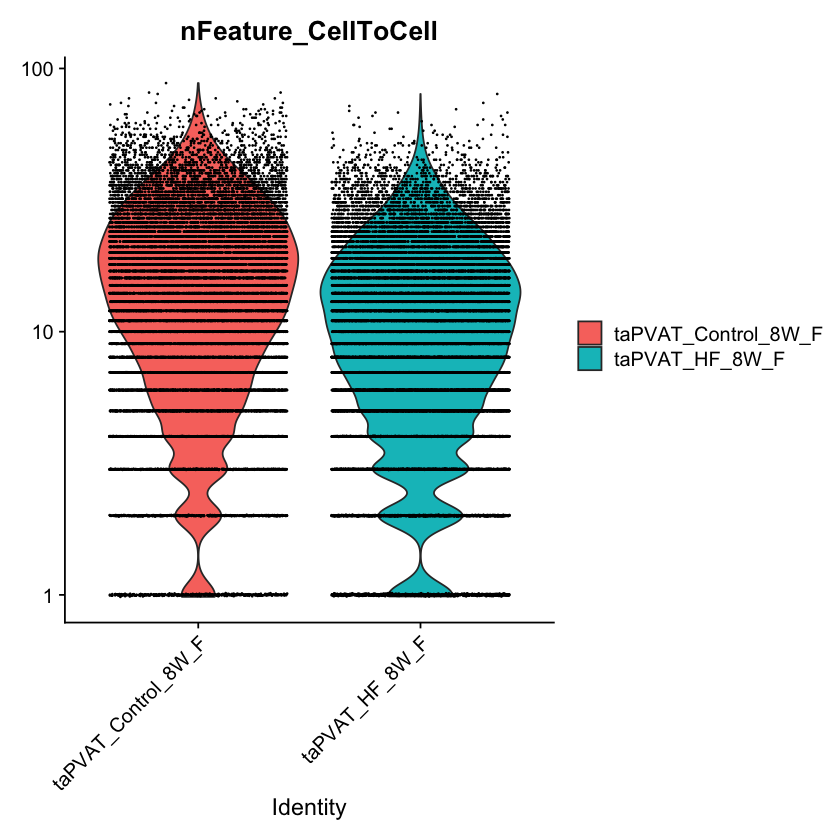

In [14]:
# Merge together
scc.merge <- merge(temp.list[[1]],temp.list[2])

# Clean up low-information crosses (connectivity data can be very sparse)
VlnPlot(scc.merge,features = 'nFeature_CellToCell',group.by = 'Condition',pt.size=0.1,log = T)

In [15]:
scc.sub <- subset(scc.merge,nFeature_CellToCell > 5) # Requesting at least 5 distinct ligand-receptor interactions between two cells

In [16]:
unique(scc.sub$VectorType)

[1] "Adipocytes—Adipocytes"               "Adipocytes—Fibroblasts"             
 [3] "Adipocytes—Endothelial_Cells"        "Adipocytes—Immune_Cells"            
 [5] "Adipocytes—Pericytes"                "Adipocytes—Mesothelial_Cells"       
 [7] "Adipocytes—SMCs"                     "Adipocytes—Neuronal_Cells"          
 [9] "Fibroblasts—Adipocytes"              "Fibroblasts—Fibroblasts"            
[11] "Fibroblasts—Endothelial_Cells"       "Fibroblasts—Immune_Cells"           
[13] "Fibroblasts—Pericytes"               "Fibroblasts—Mesothelial_Cells"      
[15] "Fibroblasts—SMCs"                    "Fibroblasts—Neuronal_Cells"         
[17] "Endothelial_Cells—Adipocytes"        "Endothelial_Cells—Fibroblasts"      
[19] "Endothelial_Cells—Endothelial_Cells" "Endothelial_Cells—Immune_Cells"     
[21] "Endothelial_Cells—Pericytes"         "Endothelial_Cells—Mesothelial_Cells"
[23] "Endothelial_Cells—SMCs"              "Endothelial_Cells—Neuronal_Cells"   
[25] "Immune_Cells—Adipocytes"             "Immune_Cells—Fibroblasts"           
[27] "Immune_Cells—Endothelial_Cells"      "Immune_Cells—Immune_Cells"          
[29] "Immune_Cells—Pericytes"              "Immune_Cells—Mesothelial_Cells"     
[31] "Immune_Cells—SMCs"                   "Immune_Cells—Neuronal_Cells"        
[33] "Pericytes—Adipocytes"                "Pericytes—Fibroblasts"              
[35] "Pericytes—Endothelial_Cells"         "Pericytes—Immune_Cells"             
[37] "Pericytes—Pericytes"                 "Pericytes—Mesothelial_Cells"        
[39] "Pericytes—SMCs"                      "Pericytes—Neuronal_Cells"           
[41] "Mesothelial_Cells—Adipocytes"        "Mesothelial_Cells—Fibroblasts"      
[43] "Mesothelial_Cells—Endothelial_Cells" "Mesothelial_Cells—Immune_Cells"     
[45] "Mesothelial_Cells—Pericytes"         "Mesothelial_Cells—Mesothelial_Cells"
[47] "Mesothelial_Cells—SMCs"              "Mesothelial_Cells—Neuronal_Cells"   
[49] "SMCs—Adipocytes"                     "SMCs—Fibroblasts"                   
[51] "SMCs—Endothelial_Cells"              "SMCs—Immune_Cells"                  
[53] "SMCs—Pericytes"                      "SMCs—Mesothelial_Cells"             
[55] "SMCs—SMCs"                           "SMCs—Neuronal_Cells"                
[57] "Neuronal_Cells—Adipocytes"           "Neuronal_Cells—Fibroblasts"         
[59] "Neuronal_Cells—Endothelial_Cells"    "Neuronal_Cells—Immune_Cells"        
[61] "Neuronal_Cells—Pericytes"            "Neuronal_Cells—Mesothelial_Cells"   
[63] "Neuronal_Cells—SMCs"                 "Neuronal_Cells—Neuronal_Cells"

In [17]:
#as.data.frame(GetAssayData(scc.list$taPVAT_Control_8W_M$CellToCell, slot = "counts"))

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama2—Itgb1, Col3a1—Itgb1, Col6a2—Itgb1, Col5a2—Itgb1, Fbn1—Itgb1, Col6a3—Itgb1, Col6a1—Itgb1, Col1a2—Itgb1, Col5a1—Itgb1, Adam12—Itgb1 
	   Col1a1—Itgb1, Lamc1—Itgb1, Lama2—Itga1, Hspg2—Itgb1, Nid1—Itgb1, Col4a1—Itgb1, Col6a2—Itga1, Lama4—Itgb1, Col4a4—Itgb1, Col5a2—Itga1 
	   Angpt1—Itgb1, Col6a3—Itga1, Col6a1—Itga1, Col4a3—Itgb1, Col1a2—Itga1, Vegfc—Itgb1, Col1a1—Itga1, Col5a1—Itga1, Lamb1—Itgb1, Lama2—Itga6 
Negative:  Vegfa—Nrp1, Sorbs1—Insr, Nrg4—Erbb4, Adipoq—Adipor2, Gnas—Adrb3, Sorbs1—Itga1, Gnas—Adcy9, Lpl—Lrp1, Psap—Lrp1, Vegfa—Itgav 
	   Nampt—Insr, Fgf1—Nrp1, Sorbs1—Itgb5, Vegfa—Nrp2, Adam17—Erbb4, Fgf1—Fgfr1, Vegfb—Nrp1, Psap—Sort1, Gnas—Adora1, Gnas—Tshr 
	   Gnas—Gcgr, Adipoq—Adipor1, Lpl—Vldlr, Col7a1—Itgb1, Vegfa—Sirpa, Nrg4—Egfr, Farp2—Plxna2, Farp2—Plxna4, Calm1—Insr, Uba52—Tgfbr2 
PC_ 2 
Positive:  Lama4—Itgb1, Col4a1—Itgb1, V

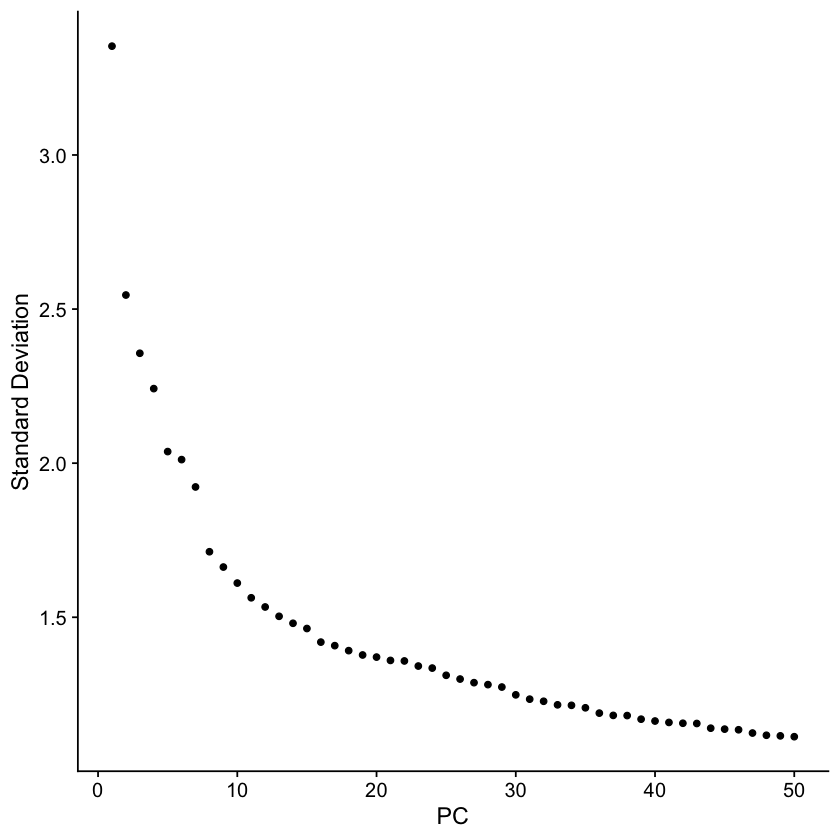

In [18]:
# Perform initial visualization
scc.sub <- ScaleData(scc.sub)
scc.sub <- FindVariableFeatures(scc.sub,selection.method = "disp")
scc.sub <- RunPCA(scc.sub,npcs = 50)
ElbowPlot(scc.sub,ndim=50)

21:57:21 UMAP embedding parameters a = 0.9922 b = 1.112

21:57:21 Read 30138 rows and found 25 numeric columns

21:57:21 Using Annoy for neighbor search, n_neighbors = 30

21:57:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:57:23 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpCx3W1U/file159ab251063e8

21:57:23 Searching Annoy index using 1 thread, search_k = 3000

21:57:31 Annoy recall = 100%

21:57:32 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

21:57:33 Initializing from normalized Laplacian + noise (using RSpectra)

21:57:34 Commencing optimization for 200 epochs, with 1296292 positive edges

21:58:00 Optimization finished



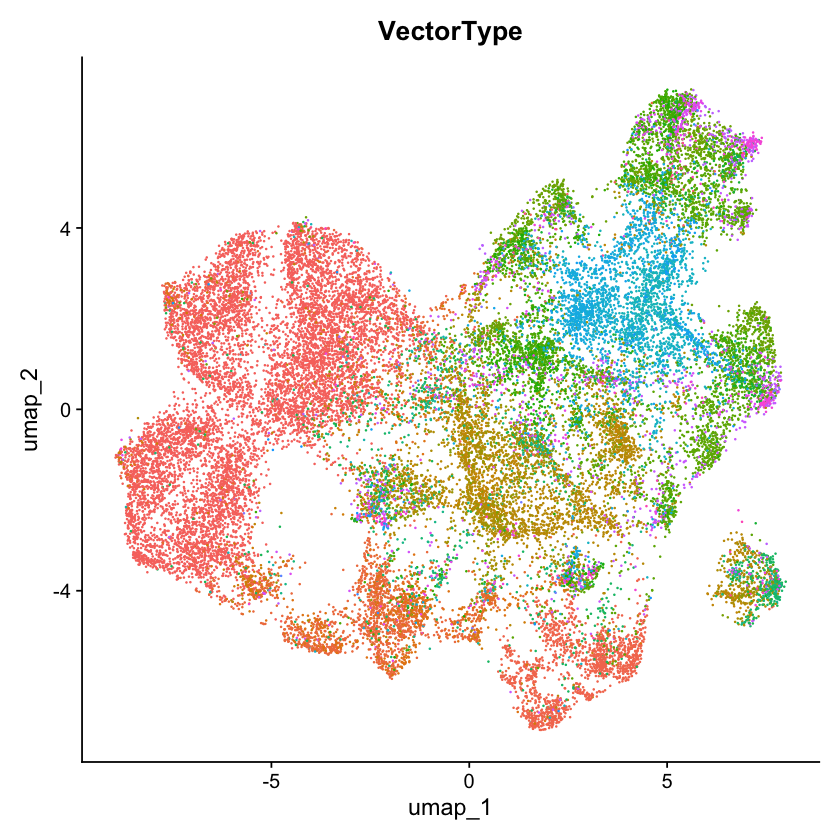

In [19]:
scc.sub <- RunUMAP(scc.sub,dims = 1:25)
DimPlot(scc.sub,group.by = 'VectorType')+NoLegend()

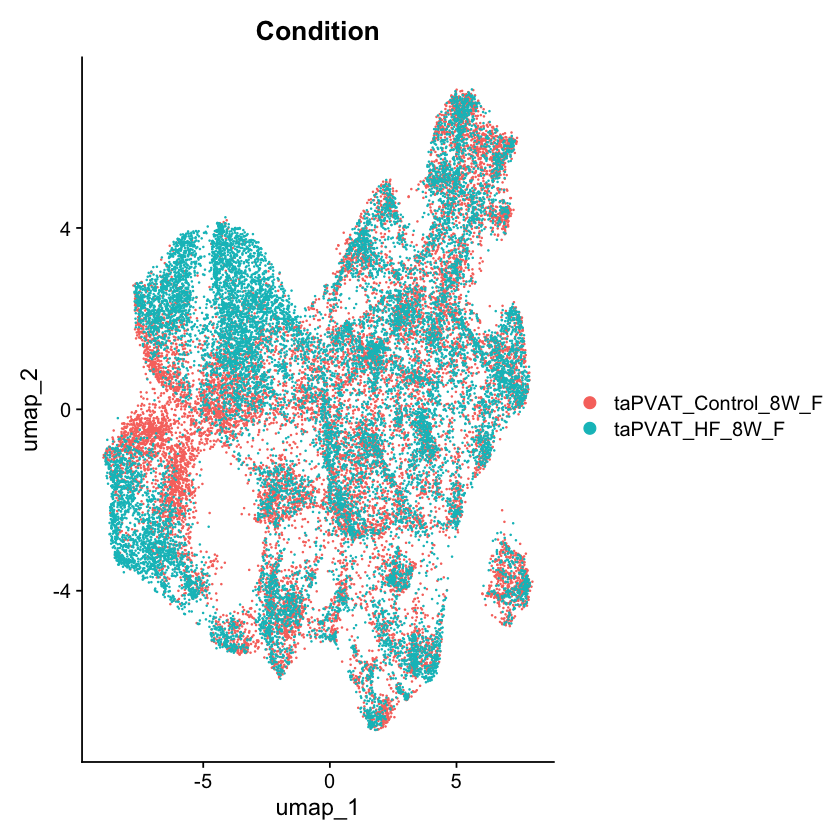

In [20]:
DimPlot(scc.sub,group.by = 'Condition')

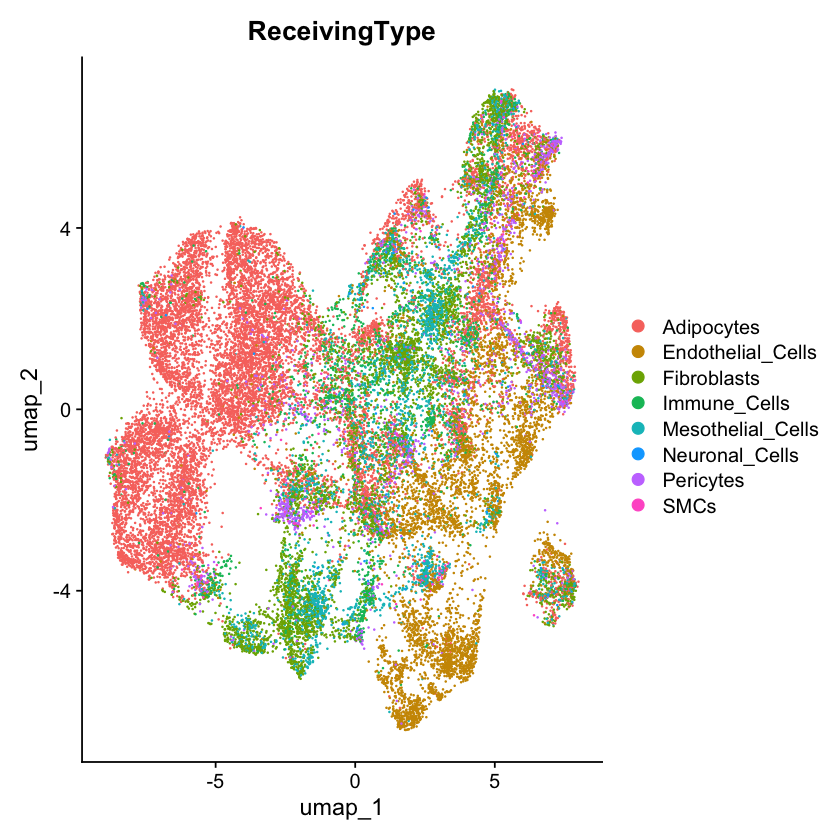

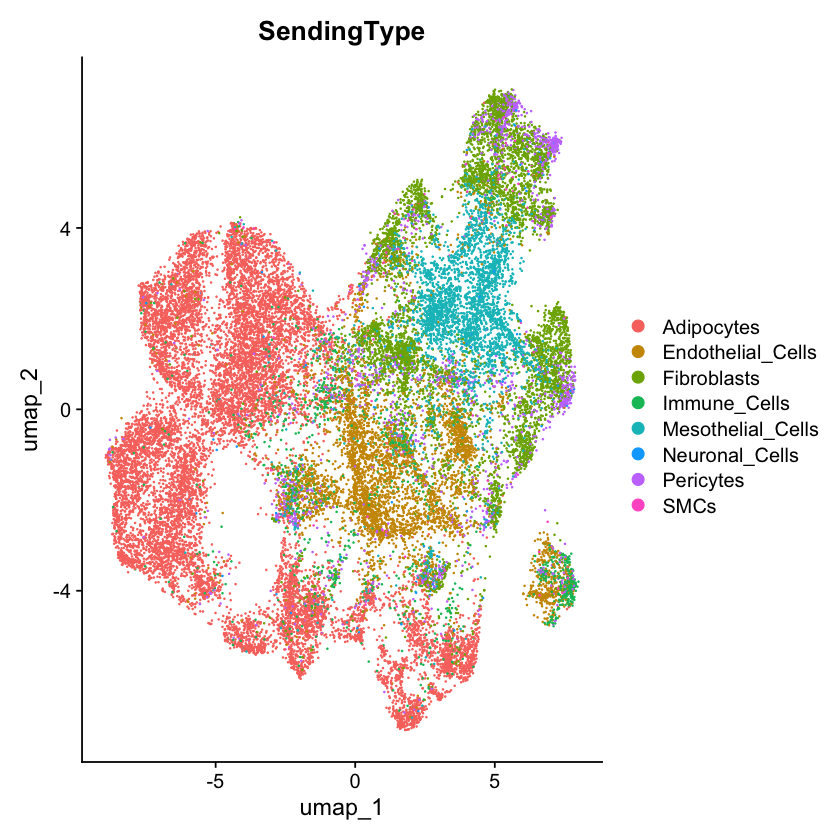

In [21]:
DimPlot(scc.sub,group.by = 'ReceivingType')
DimPlot(scc.sub,group.by = 'SendingType')

In [22]:
table(scc.sub@meta.data$VectorType)


              Adipocytes—Adipocytes        Adipocytes—Endothelial_Cells 
                               8940                                1453 
             Adipocytes—Fibroblasts             Adipocytes—Immune_Cells 
                               1455                                 512 
       Adipocytes—Mesothelial_Cells           Adipocytes—Neuronal_Cells 
                                541                                  14 
               Adipocytes—Pericytes                     Adipocytes—SMCs 
                                281                                  19 
       Endothelial_Cells—Adipocytes Endothelial_Cells—Endothelial_Cells 
                               1286                                1188 
      Endothelial_Cells—Fibroblasts      Endothelial_Cells—Immune_Cells 
                               1032                                 409 
Endothelial_Cells—Mesothelial_Cells    Endothelial_Cells—Neuronal_Cells 
                                456               

In [23]:
scc.sub@assays$CellToCell

Assay (v5) data with 802 features for 30138 cells
Top 10 variable features:
 Nxph1—Nrxn1, Sema3c—Nrp1, Col3a1—Ddr2, Vegfa—Nrp1, Igf1—Insr,
Anxa1—Egfr, Vegfa—Egfr, Lama2—Itga6, Vegfa—Flt1, Col4a1—Itga1 
Layers:
 counts.1, counts.2, data.1, data.2, scale.data 

In [24]:
rownames(GetAssayData(scc.sub, assay = "CellToCell", slot = "scale.data"))


[1] "Adam10—Axl"        "Adam10—Epha3"      "Adam12—Itga9"     
  [4] "Adam12—Itgb1"      "Adam12—Sdc4"       "Adam15—Itga5"     
  [7] "Adam15—Itga9"      "Adam15—Itgav"      "Adam15—Itgb1"     
 [10] "Adam15—Itgb3"      "Adam17—Erbb4"      "Adam17—Itga5"     
 [13] "Adam17—Itgb1"      "Adam17—Notch1"     "Adam23—Itga5"     
 [16] "Adam23—Itgb3"      "Adam9—Itga3"       "Adam9—Itga6"      
 [19] "Adam9—Itgav"       "Adam9—Itgb1"       "Adam9—Itgb5"      
 [22] "Adipoq—Adipor1"    "Adipoq—Adipor2"    "Adm—Calcrl"       
 [25] "Agrn—Lrp4"         "Alox5ap—Alox5"     "Angpt1—Itga5"     
 [28] "Angpt1—Itgb1"      "Angpt1—Tek"        "Angpt1—Tie1"      
 [31] "Angpt2—Tek"        "Angpt2—Tie1"       "Angptl1—Tek"      
 [34] "Angptl2—Tie1"      "Angptl4—Tie1"      "Anxa1—Dysf"       
 [37] "Anxa1—Egfr"        "Apoe—Ldlr"         "Apoe—Lrp1"        
 [40] "Apoe—Lrp5"         "Apoe—Scarb1"       "Apoe—Sorl1"       
 [43] "Apoe—Vldlr"        "App—Cav1"          "App—Cd74"         
 [46] "App—Lrp1"          "App—Ncstn"         "App—Tnfrsf21"     
 [49] "B2m—Cd247"         "B2m—Tfrc"          "Bgn—Ly96"         
 [52] "Bgn—Tlr4"          "Bmp4—Acvr1"        "Bmp4—Acvr2a"      
 [55] "Bmp4—Acvr2b"       "Bmp4—Bmpr1a"       "Bmp4—Bmpr1b"      
 [58] "Bmp4—Bmpr2"        "Bmp5—Acvr1"        "Bmp5—Acvr2a"      
 [61] "Bmp5—Acvr2b"       "Bmp5—Bmpr1a"       "Bmp5—Bmpr1b"      
 [64] "Bmp5—Bmpr2"        "Bmp6—Acvr1"        "Bmp6—Acvr2a"      
 [67] "Bmp6—Acvr2b"       "Bmp6—Bmpr1a"       "Bmp6—Bmpr1b"      
 [70] "Bmp6—Bmpr2"        "C1qa—Cd93"         "C1qa—Cspg4"       
 [73] "C1qb—Lrp1"         "C4b—Cd46"          "Calm1—Abca1"      
 [76] "Calm1—Adcyap1r1"   "Calm1—Cacna1c"     "Calm1—Egfr"       
 [79] "Calm1—Fas"         "Calm1—Glp2r"       "Calm1—Insr"       
 [82] "Calm1—Kcnn4"       "Calm1—Kcnq1"       "Calm1—Kcnq5"      
 [85] "Calm1—Mylk"        "Calm1—Oprm1"       "Calm1—Pde1a"      
 [88] "Calm1—Pde1c"       "Calm1—Ptpra"       "Calm1—Sctr"       
 [91] "Calm1—Trpc3"       "Calm2—Abca1"       "Calm2—Egfr"       
 [94] "Calm2—Insr"        "Calm2—Kcnq1"       "Calm2—Kcnq5"      
 [97] "Calm2—Mylk"        "Calm2—Pde1a"       "Calm2—Pde1c"      
[100] "Calr—Itga2b"       "Calr—Itga3"        "Calr—Itgav"       
[103] "Calr—Lrp1"         "Calr—Scarf1"       "Calr—Tshr"        
[106] "Cfh—Itgam"         "Cgn—F11r"          "Cgn—Ocln"         
[109] "Cgn—Tgfbr1"        "Cgn—Tgfbr2"        "Clcf1—Cntfr"      
[112] "Clcf1—Il6st"       "Clcf1—Lifr"        "Cntf—Cntfr"       
[115] "Cntf—Il6st"        "Cntf—Lifr"         "Cntn4—Ptprg"      
[118] "Col14a1—Cd44"      "Col18a1—Gpc4"      "Col18a1—Itga5"    
[121] "Col18a1—Itgb1"     "Col18a1—Kdr"       "Col1a1—Cd44"      
[124] "Col1a1—Cd93"       "Col1a1—Ddr1"       "Col1a1—Ddr2"      
[127] "Col1a1—Flt4"       "Col1a1—Itga1"      "Col1a1—Itga11"    
[130] "Col1a1—Itga5"      "Col1a1—Itgav"      "Col1a1—Itgb1"     
[133] "Col1a2—Cd44"       "Col1a2—Cd93"       "Col1a2—Flt4"      
[136] "Col1a2—Itga1"      "Col1a2—Itga11"     "Col1a2—Itga2b"    
[139] "Col1a2—Itgav"      "Col1a2—Itgb1"      "Col1a2—Itgb3"     
[142] "Col3a1—Ddr1"       "Col3a1—Ddr2"       "Col3a1—Itgb1"     
[145] "Col4a1—Cd47"       "Col4a1—Cd93"       "Col4a1—Itga1"     
[148] "Col4a1—Itgav"      "Col4a1—Itgb1"      "Col4a1—Itgb8"     
[151] "Col4a2—Cd93"       "Col4a3—Cd47"       "Col4a3—Cd93"      
[154] "Col4a3—Itga1"      "Col4a3—Itgav"      "Col4a3—Itgb1"     
[157] "Col4a4—Cd47"       "Col4a4—Cd93"       "Col4a4—Itga1"     
[160] "Col4a4—Itgav"      "Col4a4—Itgb1"      "Col4a5—Cd47"      
[163] "Col4a5—Cd93"       "Col4a5—Itga1"      "Col4a5—Itgav"     
[166] "Col4a5—Itgb1"      "Col4a6—Cd47"       "Col4a6—Cd93"      
[169] "Col4a6—Itga1"      "Col4a6—Itgav"      "Col4a6—Itgb1"     
[172] "Col5a1—Itga1"      "Col5a1—Itgb1"      "Col5a1—Sdc3"      
[175] "Col5a2—Ddr1"       "Col5a2—Itga1"      "Col5a2—Itgb1"     
[178] "Col5a3—Sdc3"       "Col6a1—Itga1"      "Col6a1—Itga6"     
[181] "Col6a1—Itgb1"      "Col6a2—Itga1"  

In [25]:

# Loop over VectorTypes of interest, subsetting those interactions, finding markers associated with the comparison of interest (stimulus vs control) and  create a heatmap of top markers:

celltocell_heatmap <- function(VOI) {
    
results <- lapply(VOI, function(x){
 
  #subset
  subs <- subset(scc.sub, subset = VectorType == x)
  subs <- JoinLayers(subs, layers = c("data", "scale.data"))
  
  #print number of cells per condition
  print(paste0(x , ":  taPVAT_Control_8W_F:", sum(subs@meta.data$Condition == "taPVAT_Control_8W_F")))
  print(paste0(x , ":  taPVAT_HF_8W_F:", sum(subs@meta.data$Condition == "taPVAT_HF_8W_F")))
  
  #set idents
  Idents(subs) <- subs@meta.data$Condition
  
  #scale the subsetted data
  FindVariableFeatures(subs,assay='CellToCell',selection.method = "disp")
  ScaleData(subs, assay='CellToCell')
  
  #these are the features in the scaledata slot
  feats <- rownames(GetAssayData(subs, assay = "CellToCell", slot = "scale.data"))
  feats
  
  #find markers (here we use wilcox, but ROC and other tests can be used as well)
  markers <- FindAllMarkers(subs, features=feats, test.use = "wilcox",assay='CellToCell')
  
  #subset to top 10 markers per condition
  top10 <- markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
    
  list(subs = subs, top10 = top10)
  #Make a heatmap
  #plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top DE Mechanisms, CTRL vs STIM: ",x)
  
})

    return(results)
}

[1] "Fibroblasts—Adipocytes:  taPVAT_Control_8W_F:743"
[1] "Fibroblasts—Adipocytes:  taPVAT_HF_8W_F:831"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_F

Calculating cluster taPVAT_HF_8W_F



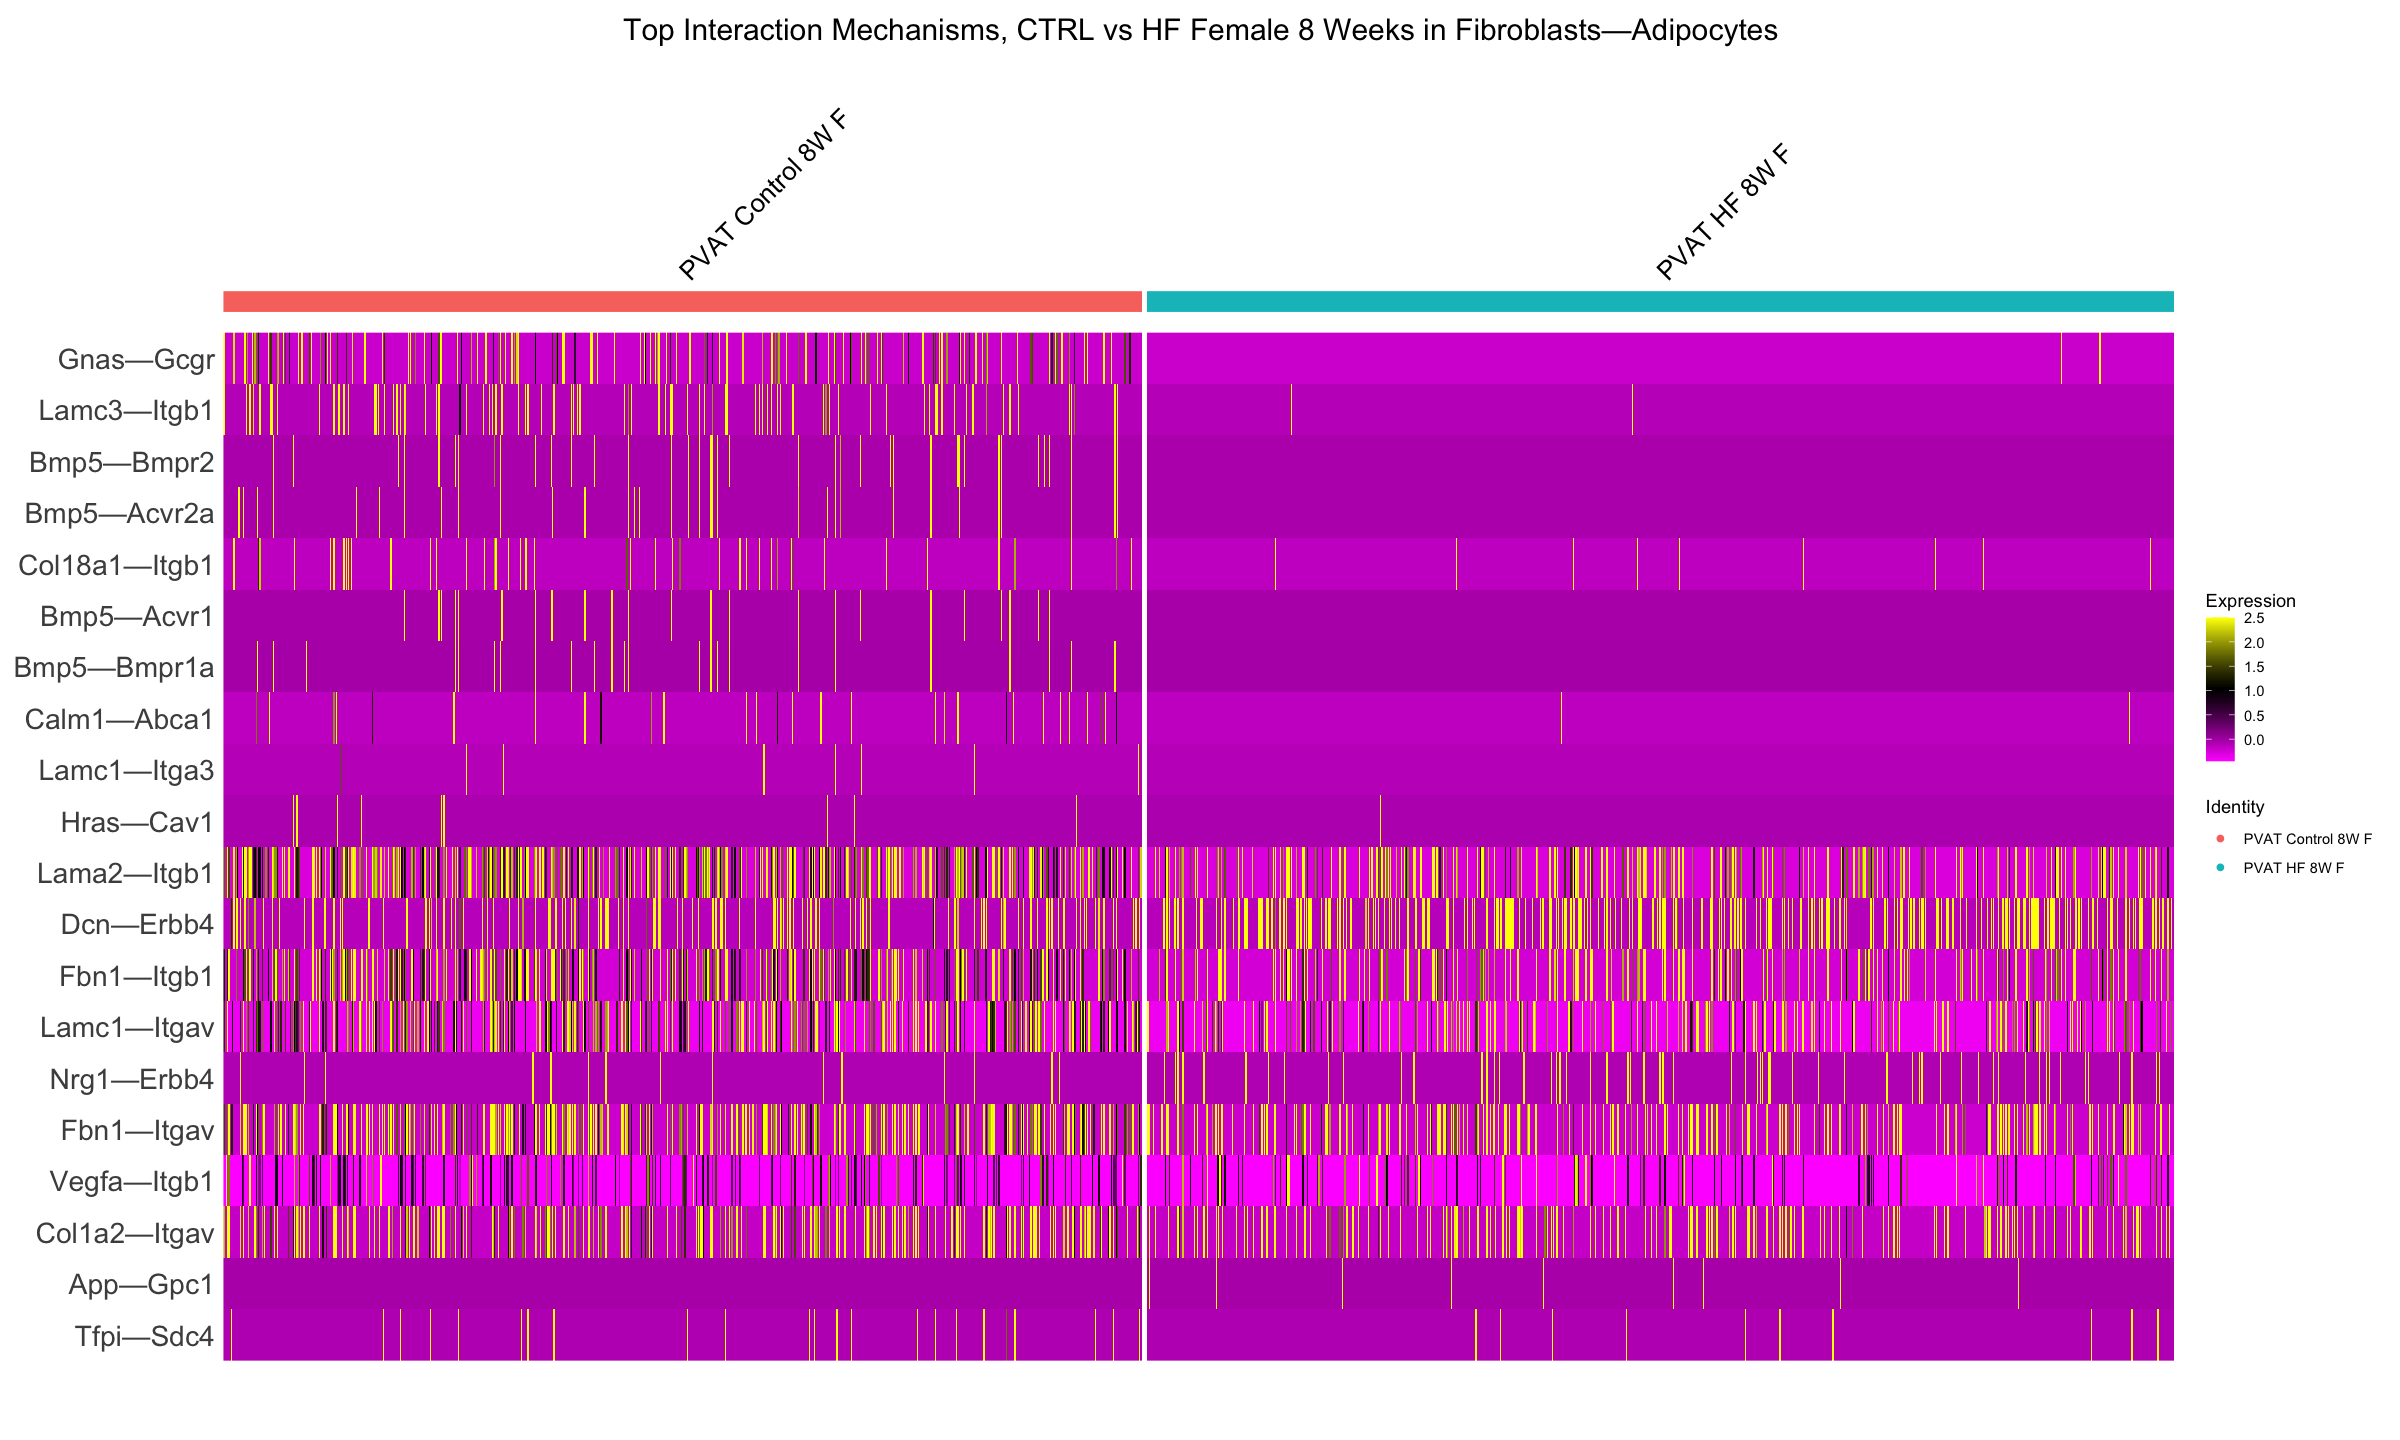

In [29]:
fibro_adipo <- celltocell_heatmap("Fibroblasts—Adipocytes")

options(repr.plot.width=20, repr.plot.height=12)
subs <- fibro_adipo[[1]]$subs
top10 <- fibro_adipo[[1]]$top10


Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_F", "taPVAT_HF_8W_F"), 
                        labels = c("PVAT Control 8W F", "PVAT HF 8W F"))


plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Fibroblasts—Adipocytes") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Fibroblasts—Adipocytes.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Fibroblasts:  taPVAT_Control_8W_F:707"
[1] "Adipocytes—Fibroblasts:  taPVAT_HF_8W_F:748"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_F

Calculating cluster taPVAT_HF_8W_F



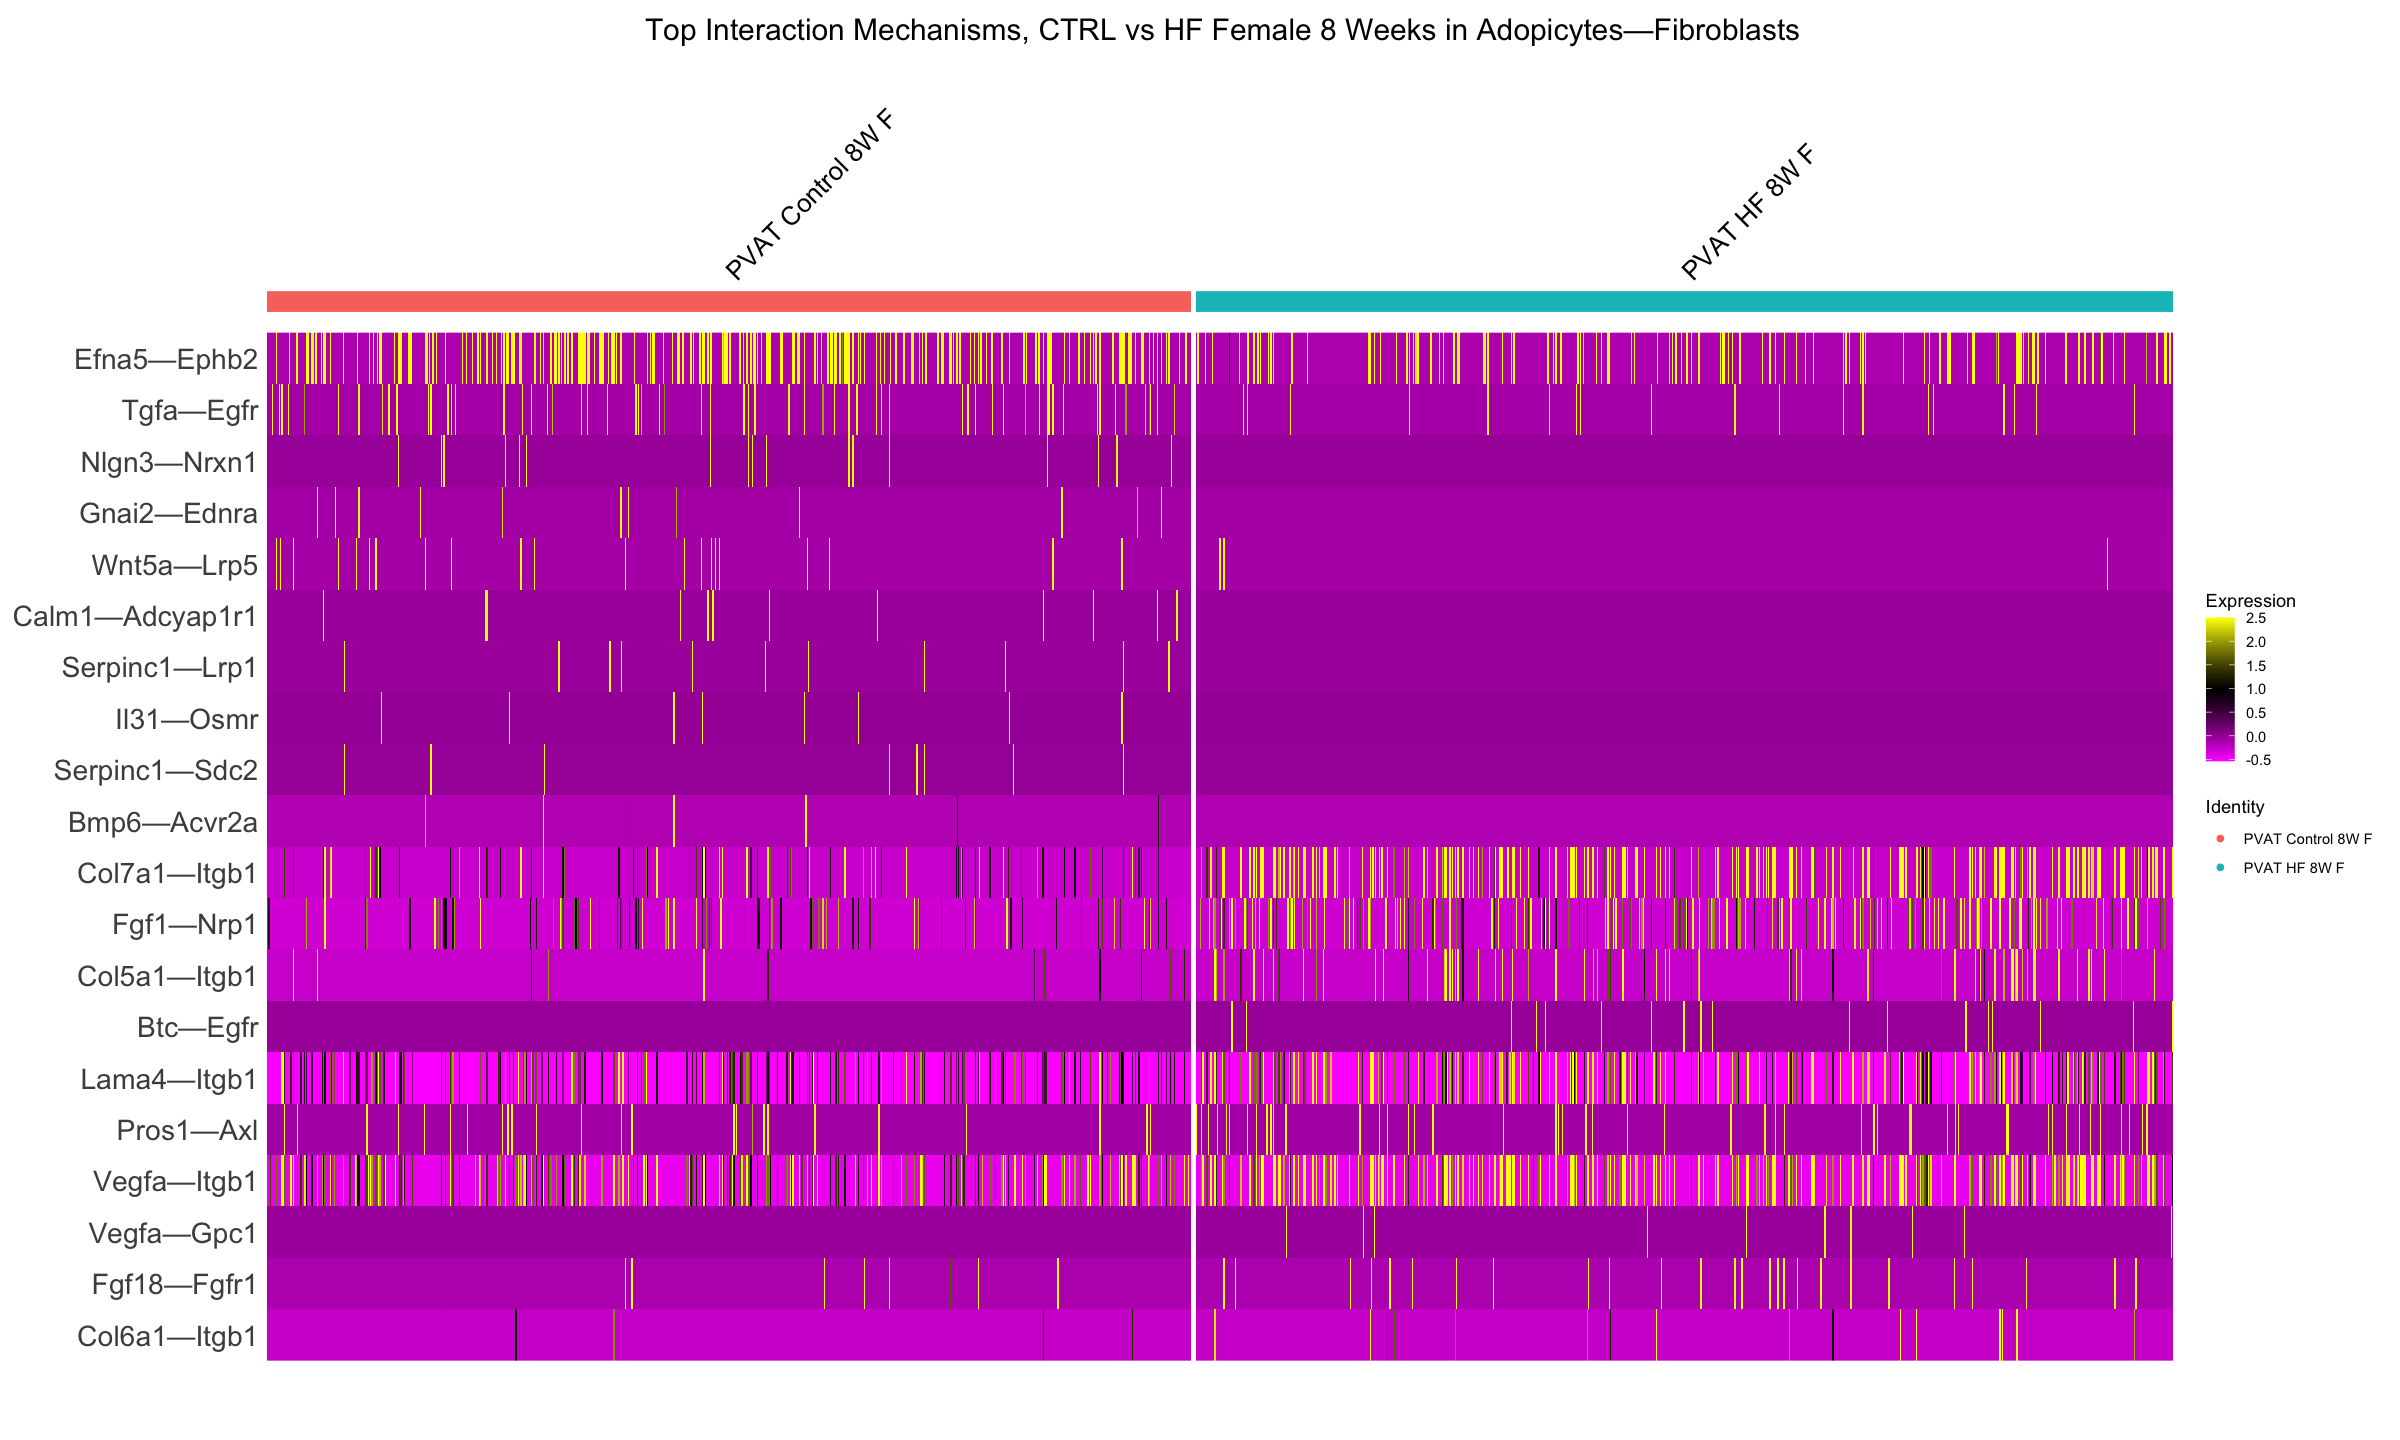

In [30]:
adipo_fibro <- celltocell_heatmap("Adipocytes—Fibroblasts")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_fibro[[1]]$subs
top10 <- adipo_fibro[[1]]$top10
Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_F", "taPVAT_HF_8W_F"), 
                        labels = c("PVAT Control 8W F", "PVAT HF 8W F"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Adopicytes—Fibroblasts") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Adopicytes—Fibroblasts.pdf", plot = plot, width = 20, height = 12, dpi = 600)

[1] "Adipocytes—Endothelial_Cells:  taPVAT_Control_8W_F:650"
[1] "Adipocytes—Endothelial_Cells:  taPVAT_HF_8W_F:803"


Finding variable features for layer data

Centering and scaling data matrix

Calculating cluster taPVAT_Control_8W_F

Calculating cluster taPVAT_HF_8W_F



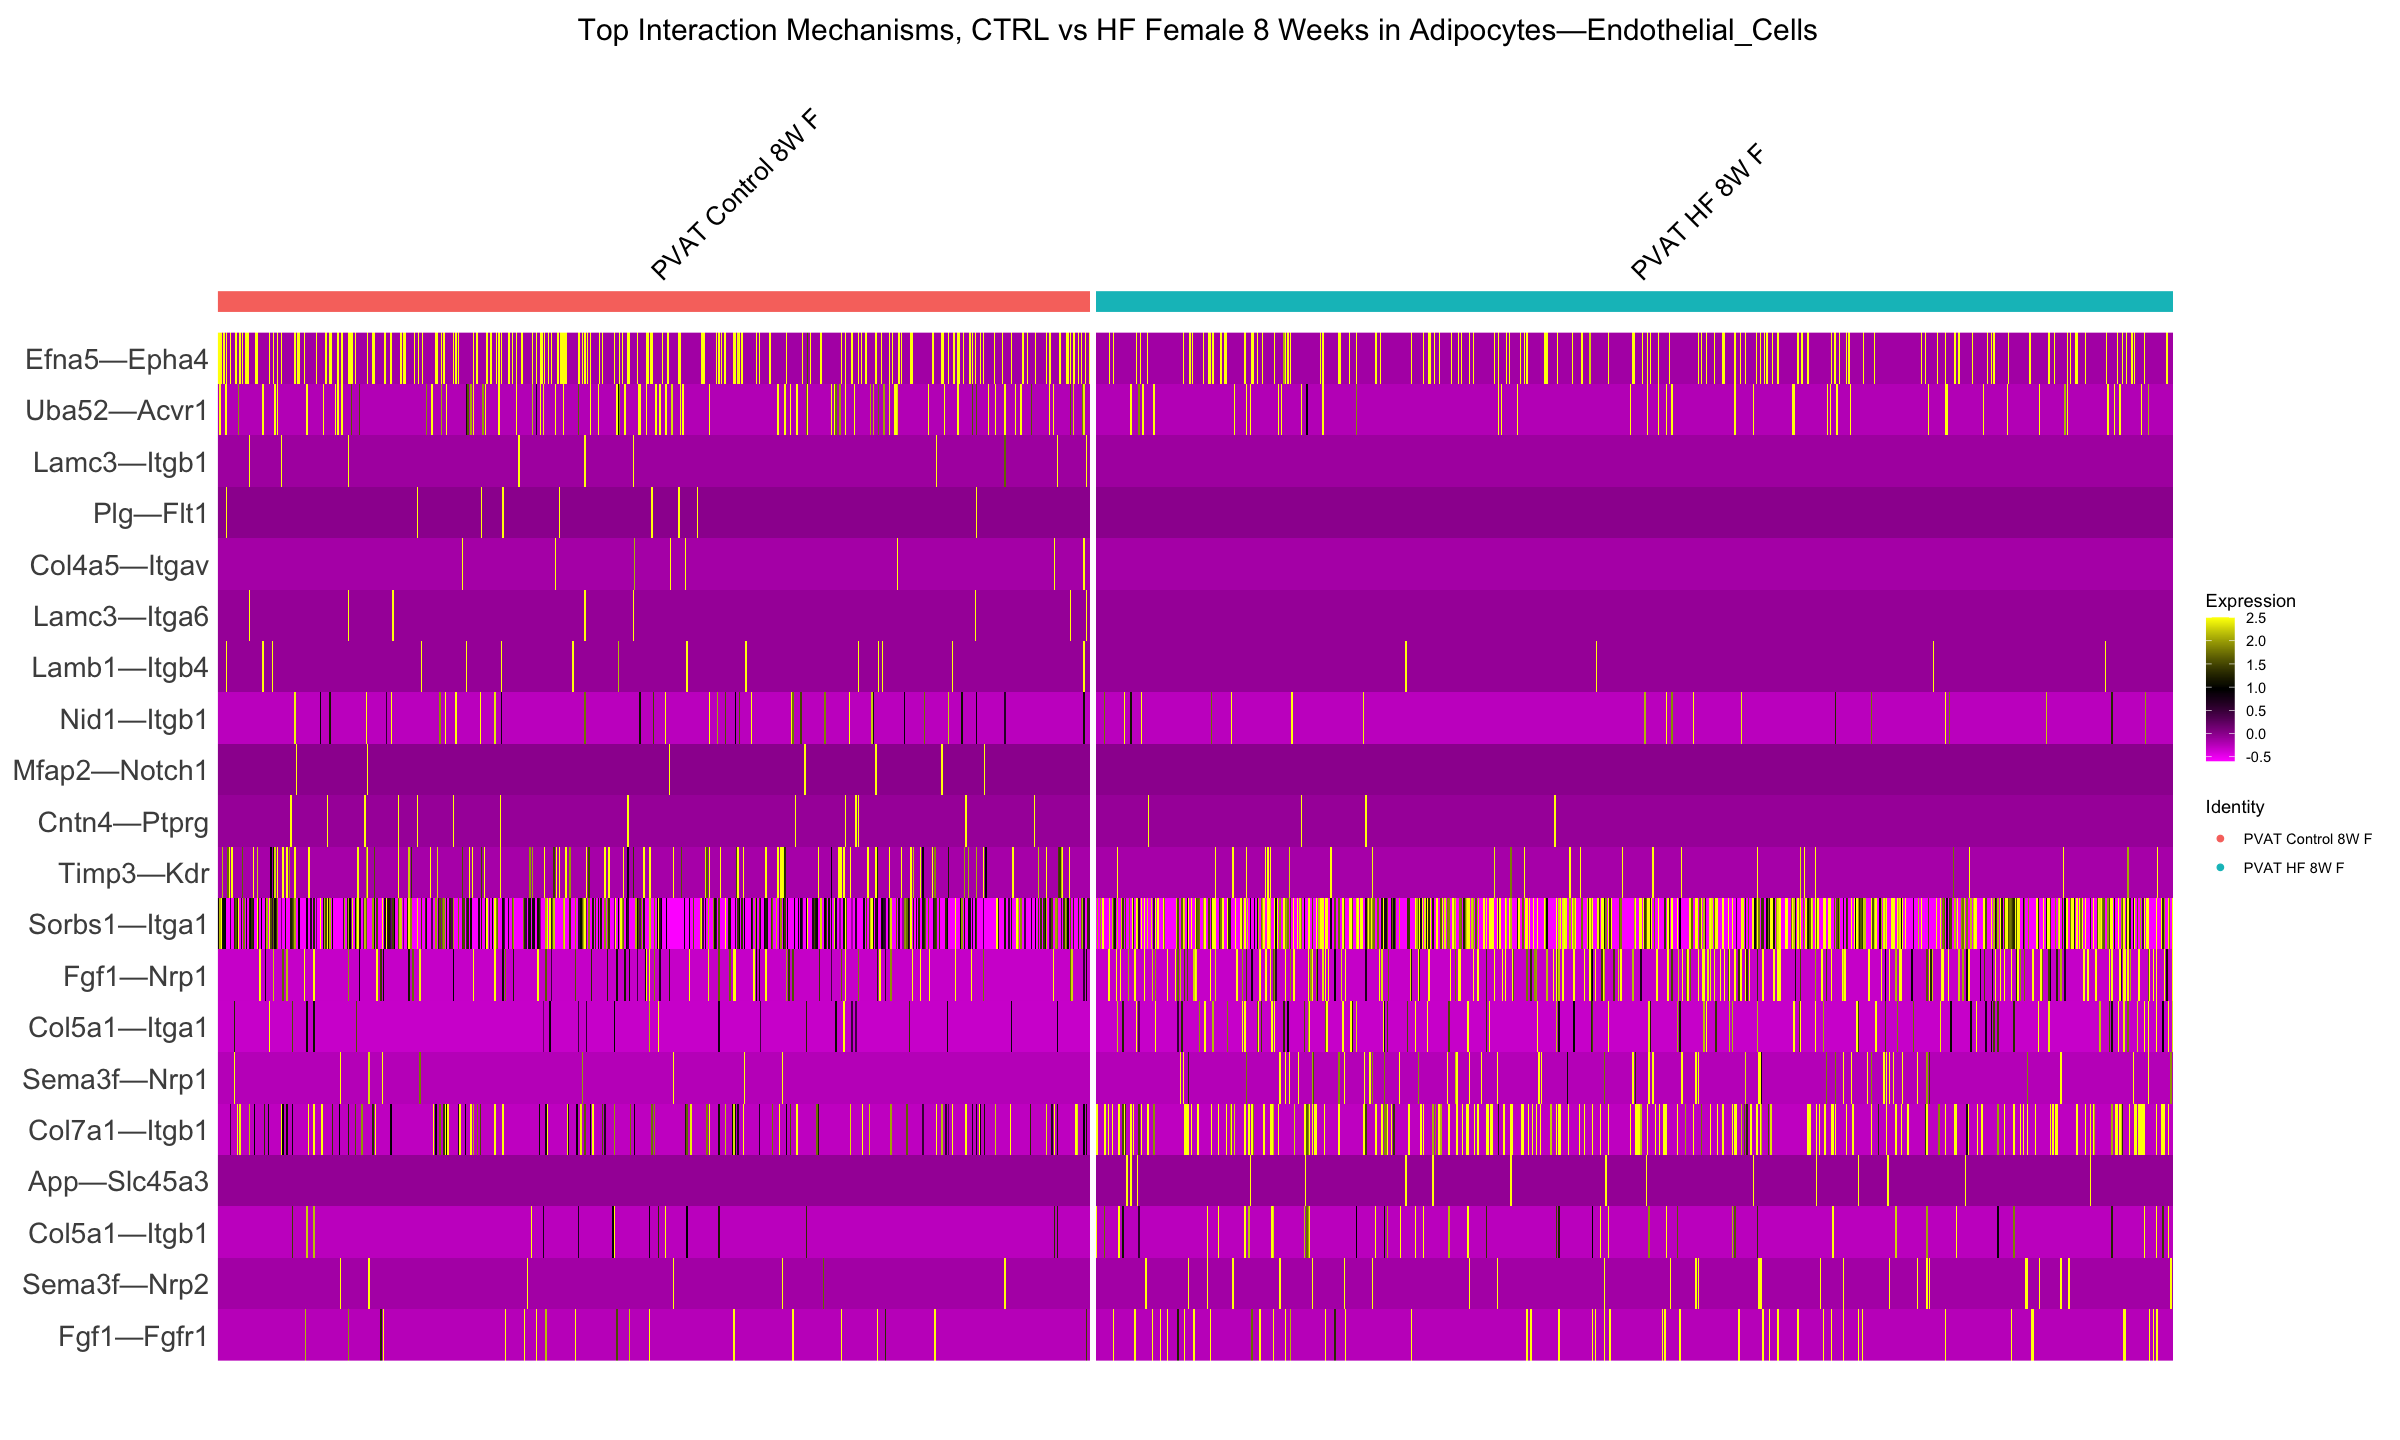

In [31]:
adipo_endo <- celltocell_heatmap("Adipocytes—Endothelial_Cells")

options(repr.plot.width=20, repr.plot.height=12)
subs <- adipo_endo[[1]]$subs
top10 <- adipo_endo[[1]]$top10
Idents(subs) <- factor(Idents(subs), levels = c("taPVAT_Control_8W_F", "taPVAT_HF_8W_F"), 
                        labels = c("PVAT Control 8W F", "PVAT HF 8W F"))

plot <- DoHeatmap(subs,group.by="ident",features=top10$gene, assay="CellToCell") +  ggtitle("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Adipocytes—Endothelial_Cells") + theme(#axis.text.x = element_text(face = "italic", size = 20),
                                                                   axis.text.y = element_text(size = 17),
                                                                   #axis.title.x = element_text(size = 20),
                                                                   #axis.title.y = element_text(size = 20),
                                                                   plot.title = element_text(hjust = 0.5, size=18))
plot

ggsave("Top Interaction Mechanisms, CTRL vs HF Female 8 Weeks in Adipocytes—Endothelial_Cells.pdf", plot = plot, width = 20, height = 12, dpi = 600)

Centering and scaling data matrix

Finding variable features for layer data.1

Finding variable features for layer data.2

PC_ 1 
Positive:  Lama2—Itgb1, Col3a1—Itgb1, Col6a2—Itgb1, Col5a2—Itgb1, Lamc1—Itgb1, Col6a3—Itgb1, Fbn1—Itgb1, Col6a1—Itgb1, Adam12—Itgb1, Col5a1—Itgb1 
	   Nid1—Itgb1, Col1a2—Itgb1, Angpt1—Itgb1, Lamb1—Itgb1, Col4a4—Itgb1, Vegfc—Itgb1, Col4a3—Itgb1, Lamc3—Itgb1, Adam9—Itgb1, Adam17—Itgb1 
	   Fn1—Itgb1, Vcan—Itgb1, Cxcl12—Itgb1, Col4a1—Itgav, Lamb1—Itgav, Nid1—Itgav, Lamb1—Itga1, Dusp18—Itgb1, Rspo3—Lrp6, Lama4—Itgav 
Negative:  Sema3c—Plxnd1, Sema3c—Nrp2, Sema3d—Nrp1, Sorbs1—Itgb5, Sema3c—Nrp1, Bmp4—Bmpr2, Sorbs1—Itga1, Col8a1—Itga1, Sema3a—Nrp2, Sema6a—Plxna4 
	   Sema6a—Plxna2, Bmp4—Bmpr1a, Igf1—Igf1r, Il15—Il2ra, Sema3a—Nrp1, Ngf—Sort1, Col5a2—Ddr1, Col3a1—Ddr1, Fn1—Itga8, Sema3a—Plxna2 
	   Apoe—Sorl1, Fgf12—Fgfr1, Tgfb1—Tgfbr3, Sema3a—Plxna4, Psap—Sort1, Dcn—Met, Vegfa—Nrp2, Apoe—Lrp1, Sorbs1—Insr, App—Lrp1 
PC_ 2 
Positive:  Rspo3—Lrp6, Hspg2—Ptprs, Adam12

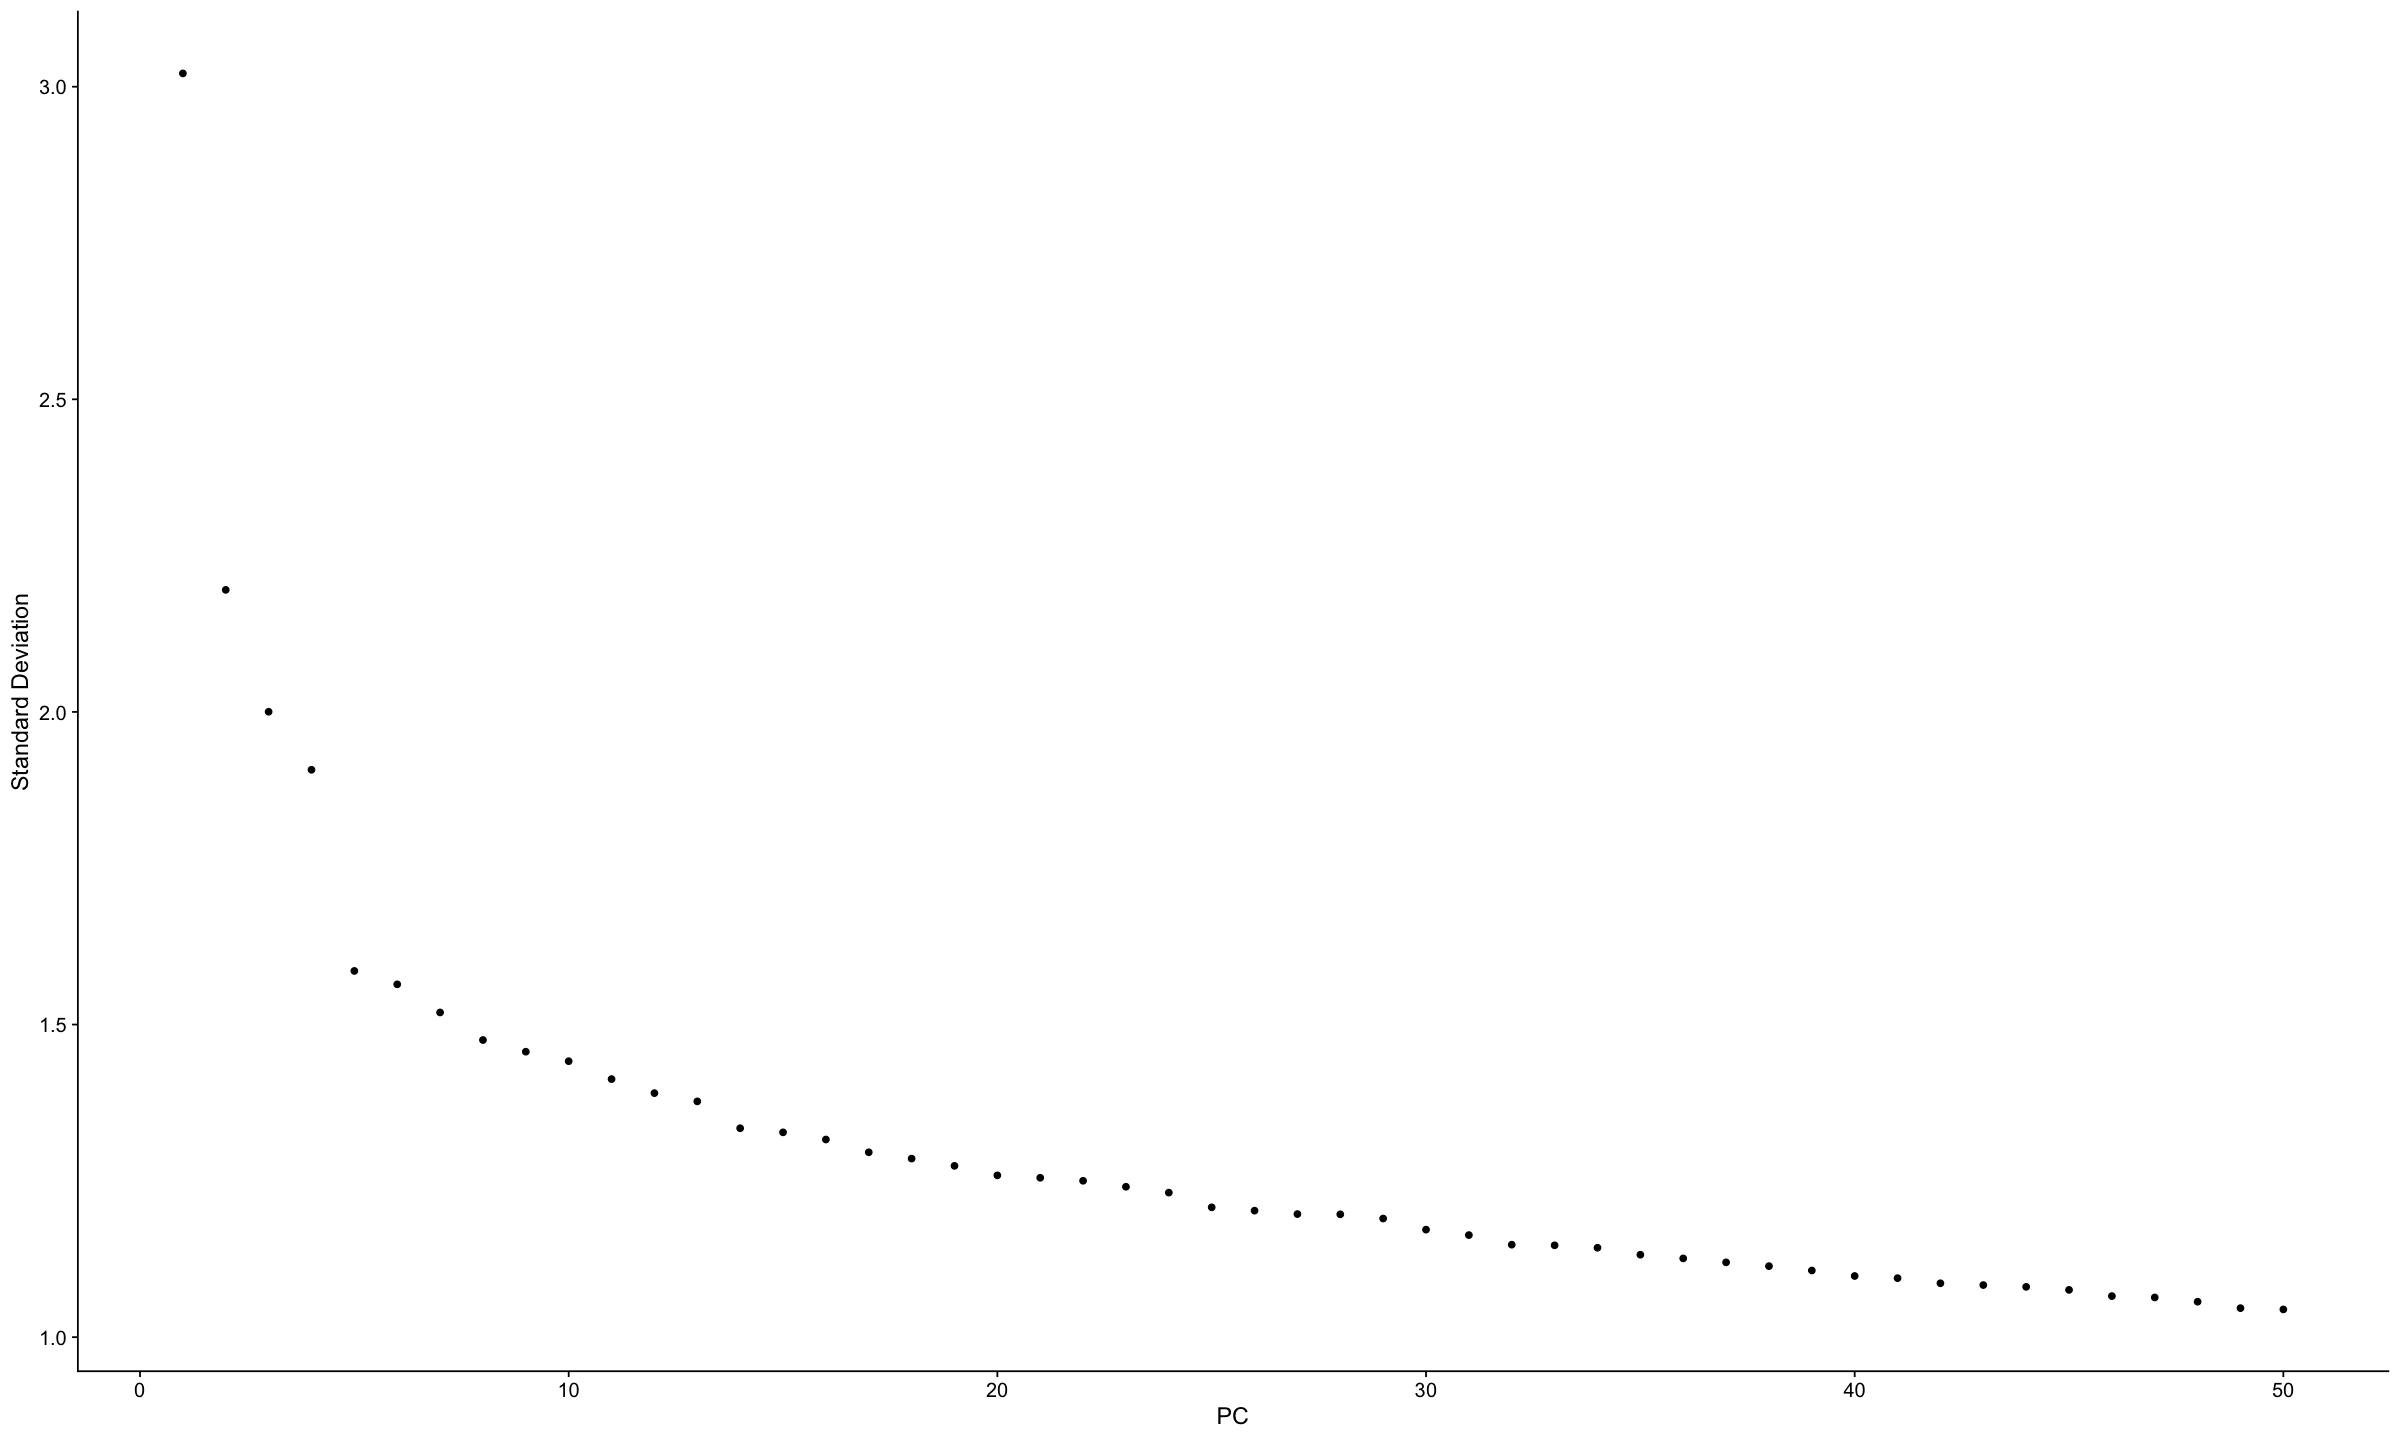

In [31]:
# Perform visualization for VectorTypes of interest
#VOI <- c("CD14 Mono—DC")
VOI <- "Fibroblasts—Adipocytes"
Idents(scc.sub) <- scc.sub@meta.data$VectorType
voi.data <- subset(scc.sub,idents = VOI)
voi.data <- ScaleData(voi.data)
voi.data <- FindVariableFeatures(voi.data,selection.method = "disp")
voi.data <- RunPCA(voi.data,npcs = 50)
ElbowPlot(voi.data,ndim=50)

14:50:01 UMAP embedding parameters a = 0.9922 b = 1.112

14:50:01 Read 1574 rows and found 10 numeric columns

14:50:01 Using Annoy for neighbor search, n_neighbors = 30

14:50:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:50:01 Writing NN index file to temp file /var/folders/kk/5gbzbkc93xb_g56p3bt9t8gh0000gp/T//RtmpxDBFSl/file10fcb54649093

14:50:01 Searching Annoy index using 1 thread, search_k = 3000

14:50:01 Annoy recall = 100%

14:50:02 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:50:02 Initializing from normalized Laplacian + noise (using RSpectra)

14:50:02 Commencing optimization for 500 epochs, with 60866 positive edges

14:50:06 Optimization finished



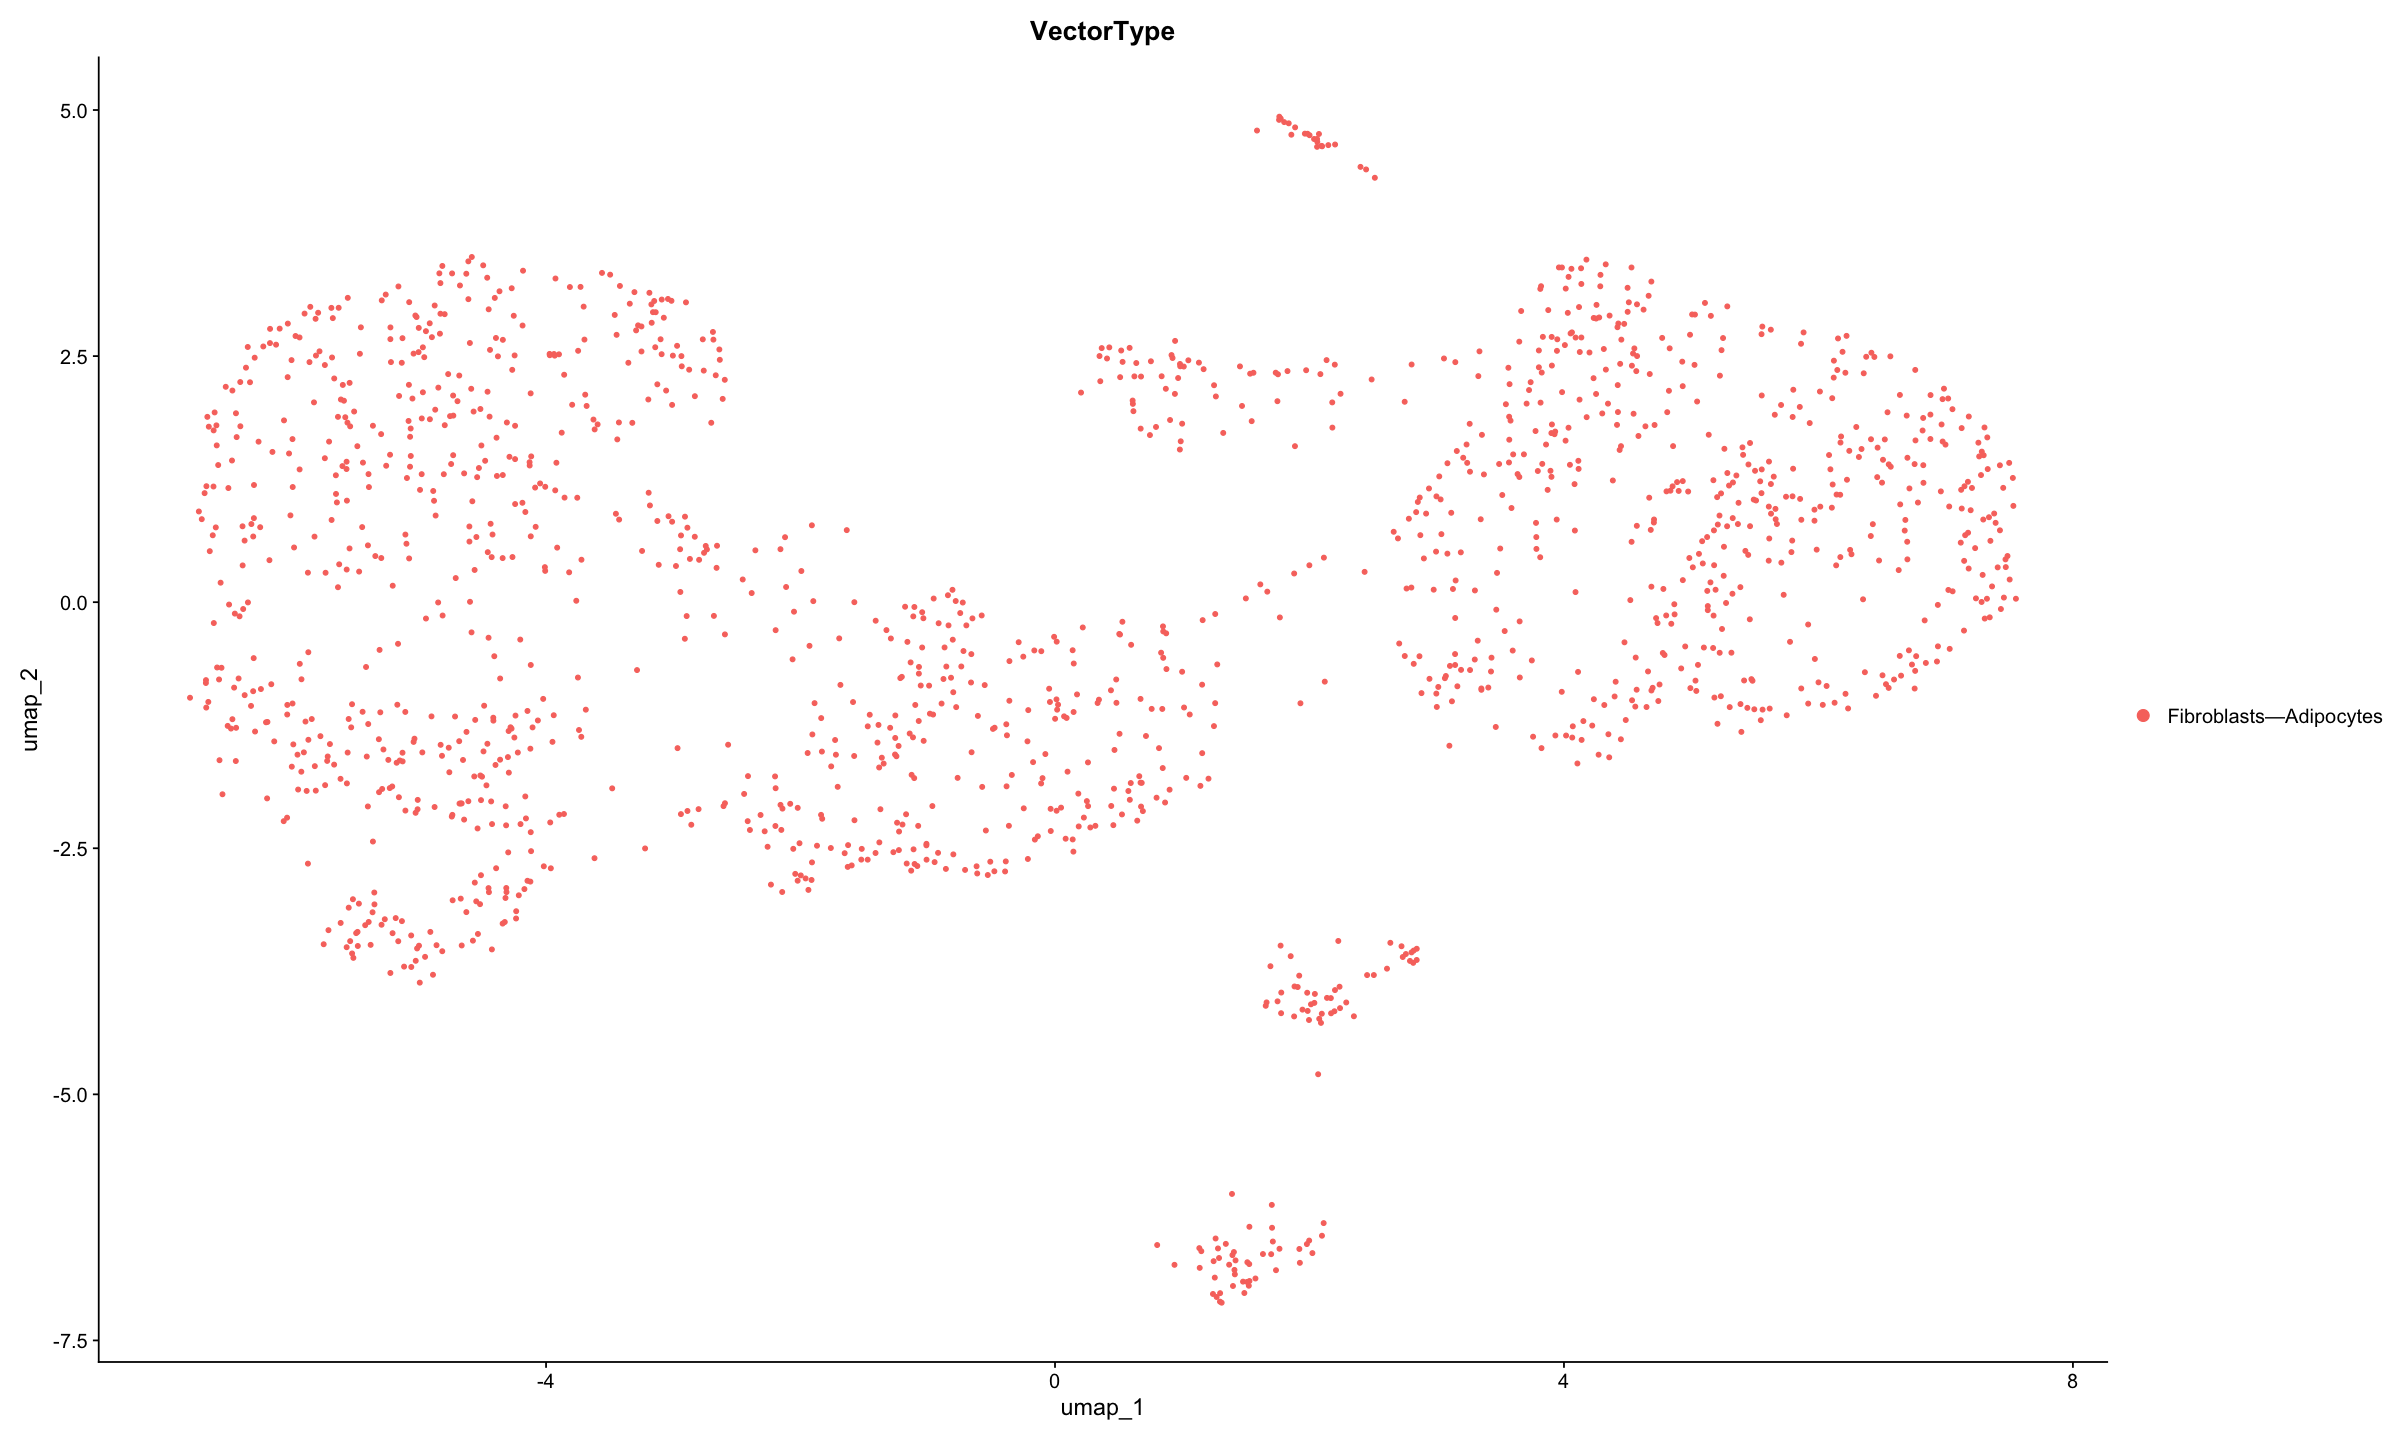

In [32]:
voi.data <- RunUMAP(voi.data,dims = 1:10)
DimPlot(voi.data,group.by = 'VectorType')

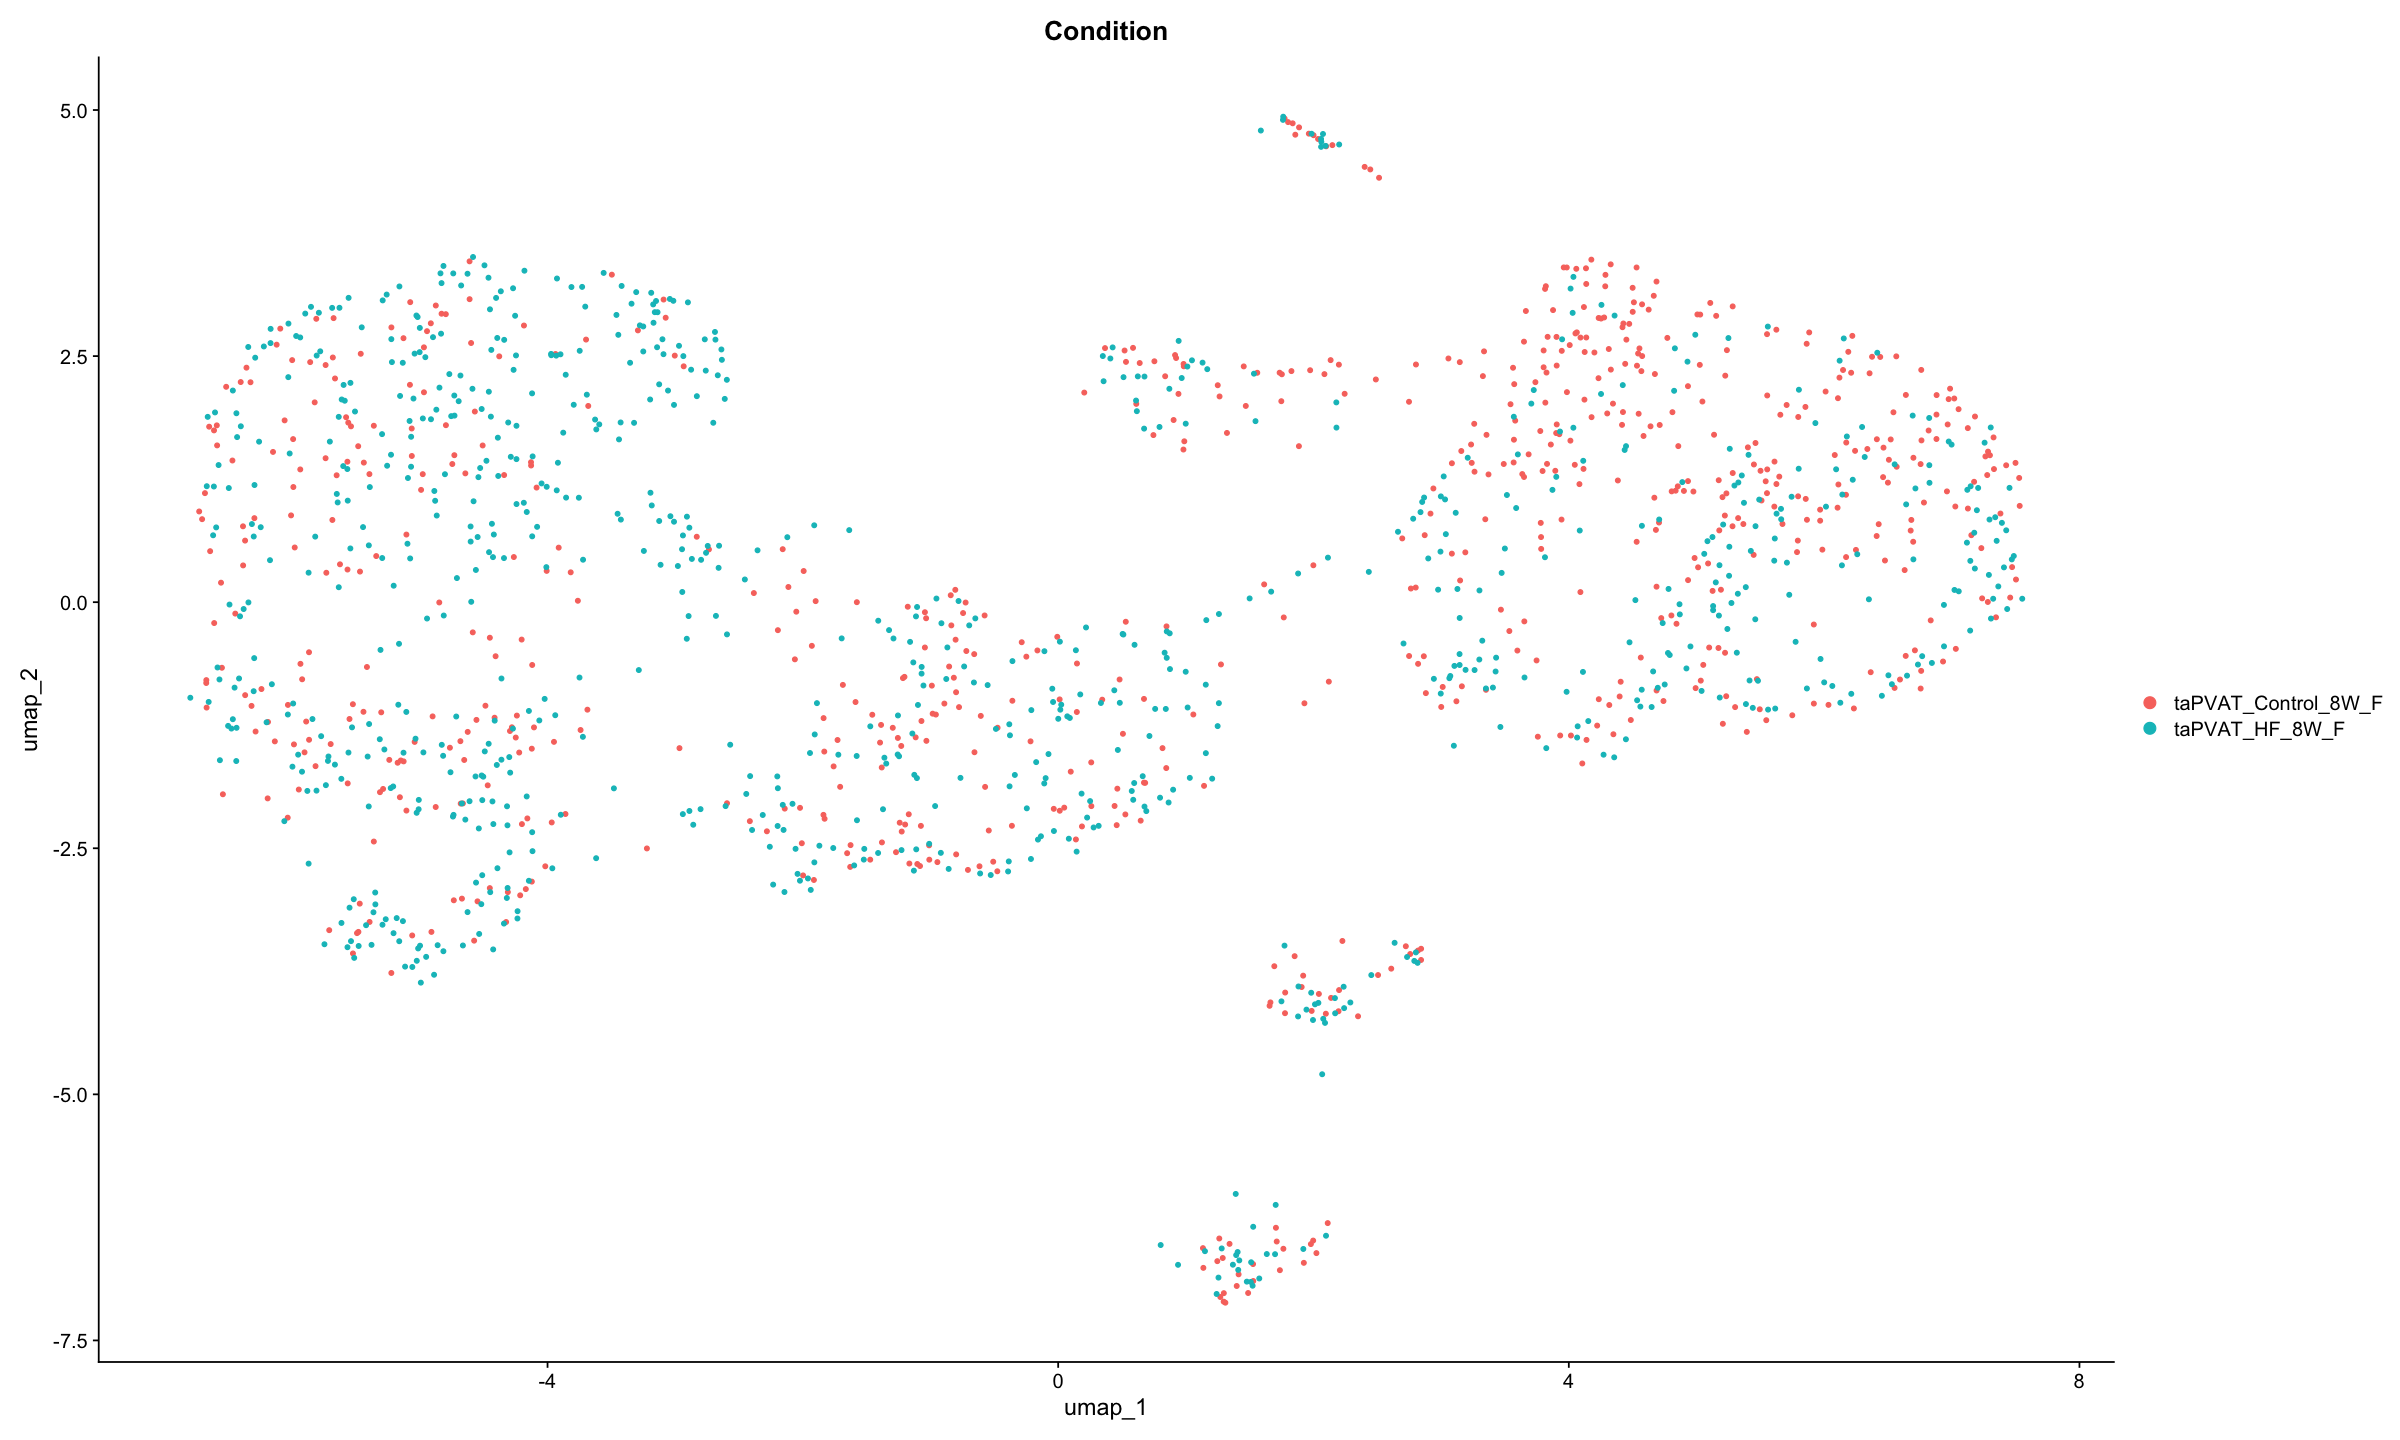

In [33]:
DimPlot(voi.data,group.by = 'Condition')

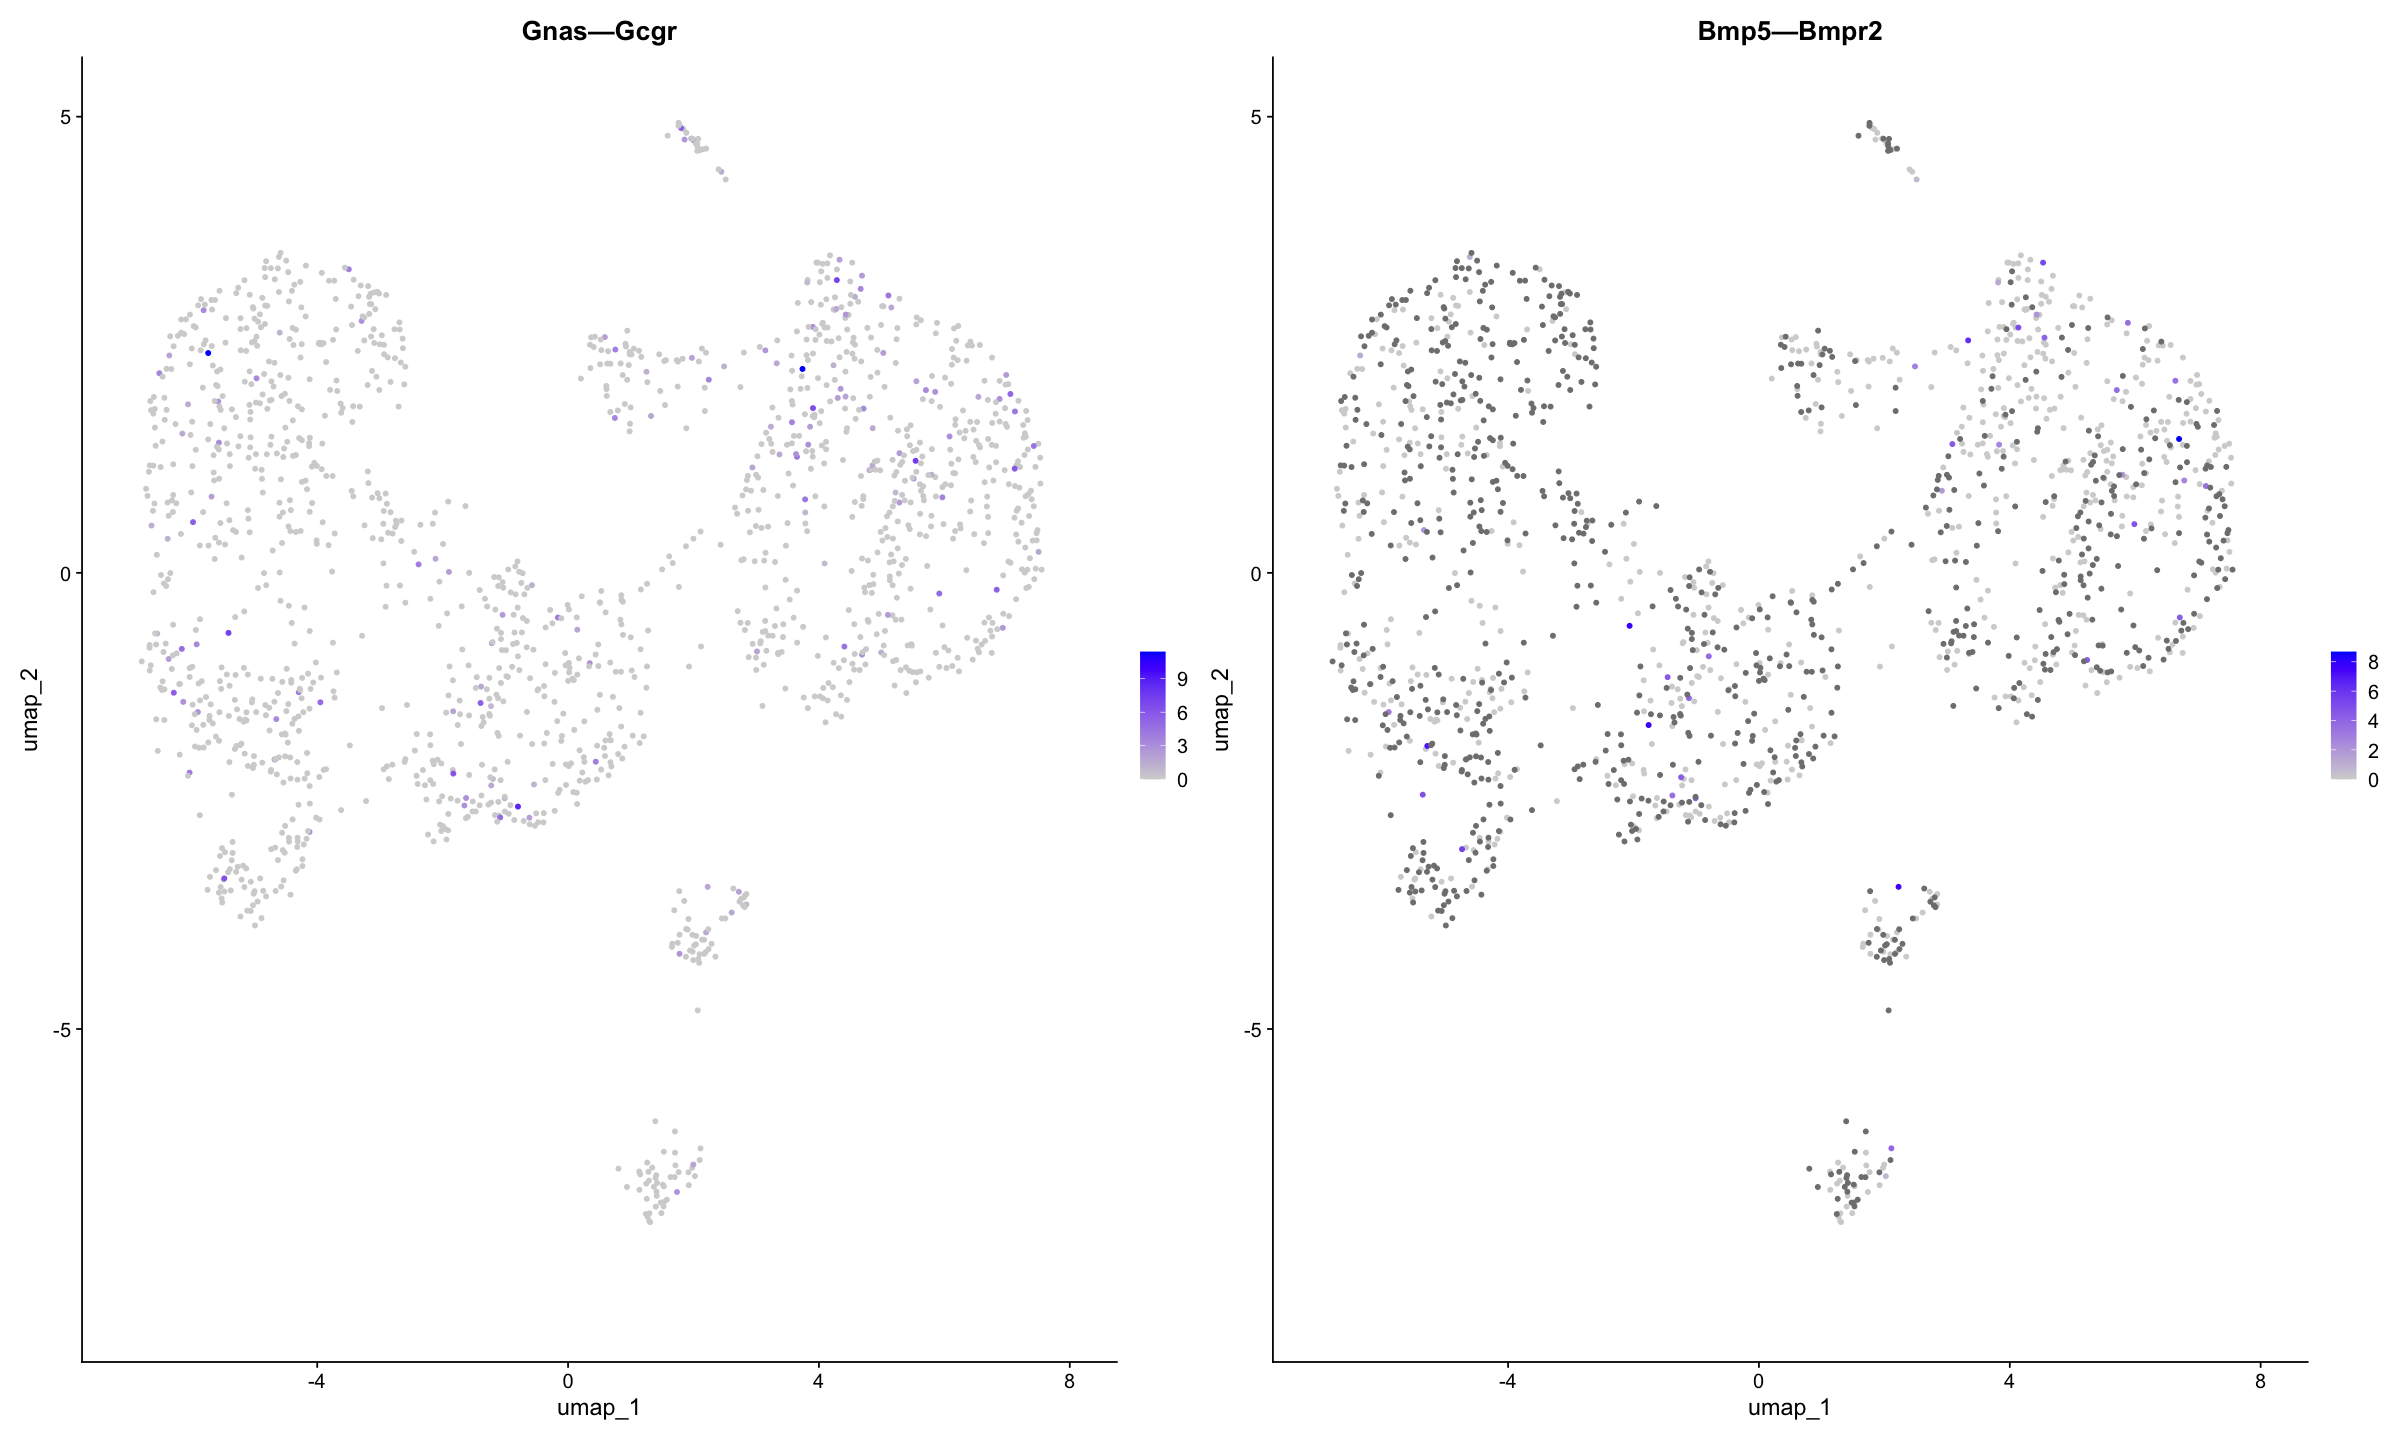

In [34]:
FeaturePlot(voi.data,
            features = c('Gnas—Gcgr','Bmp5—Bmpr2', 'Col11a1—Itgb1'),max.cutoff = 150)

In [35]:
voi.data <- JoinLayers(object = voi.data, assay = "CellToCell", layers = c("data", "scale.data"))

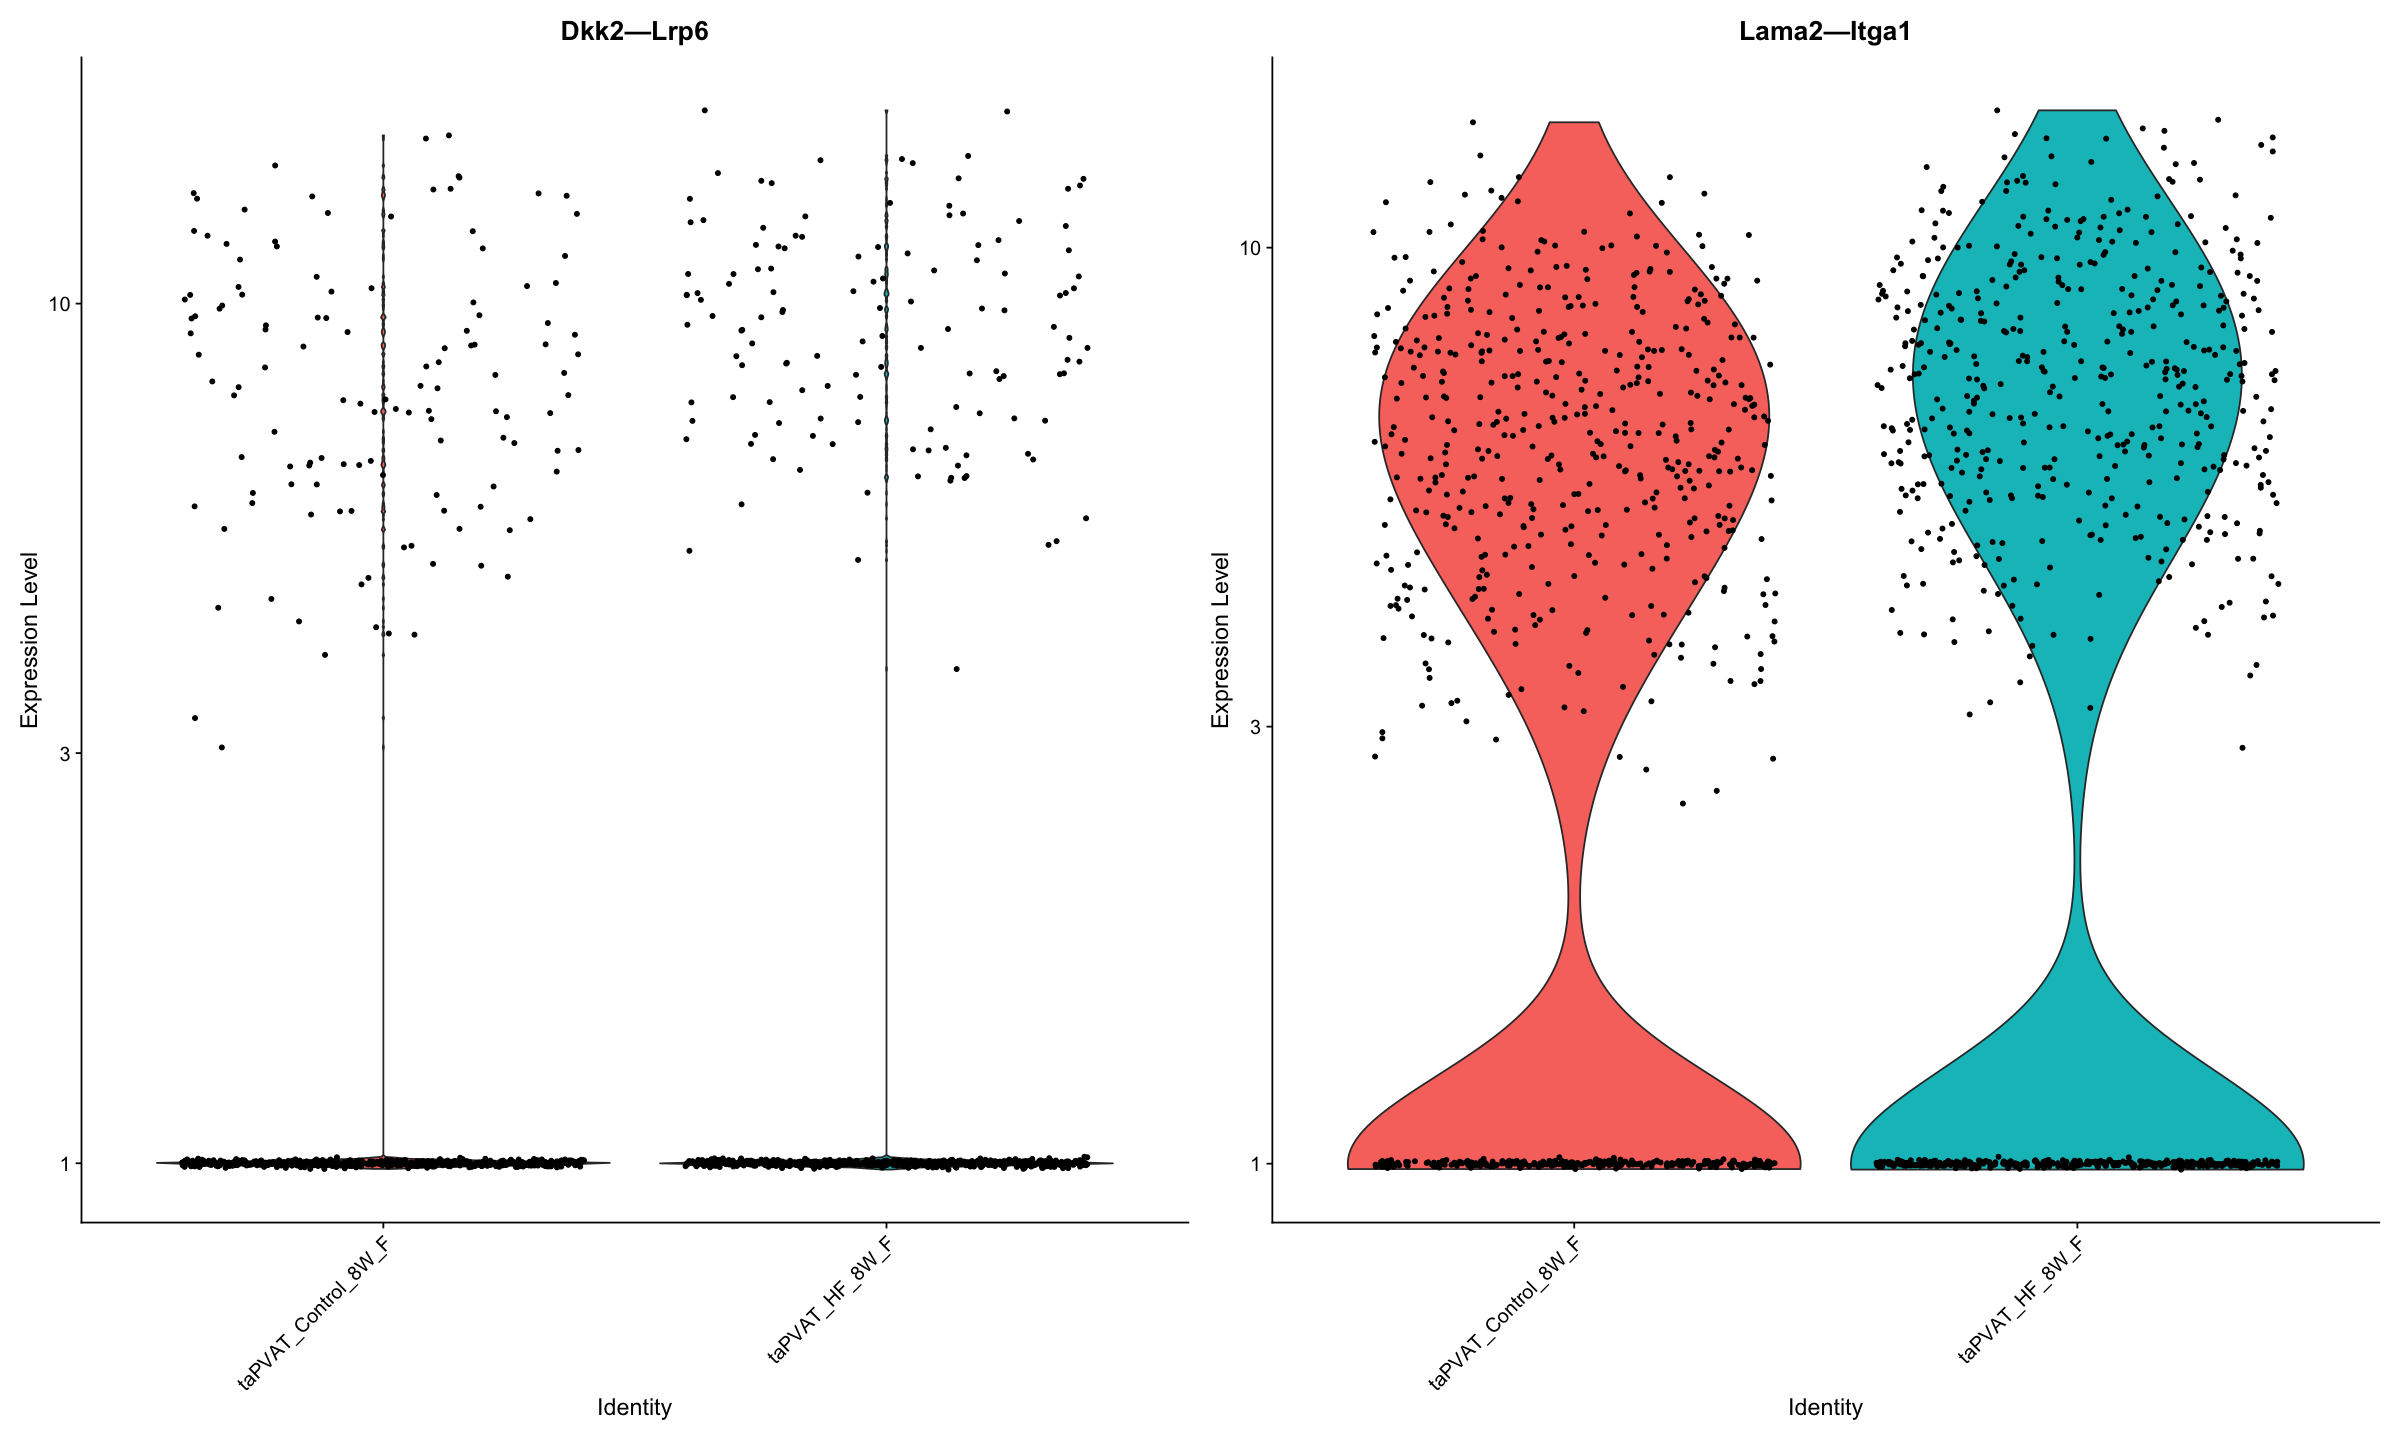

In [36]:
VlnPlot(voi.data,
            features = c('Dkk2—Lrp6','Lama2—Itga1'),log = T,group.by = 'Condition')

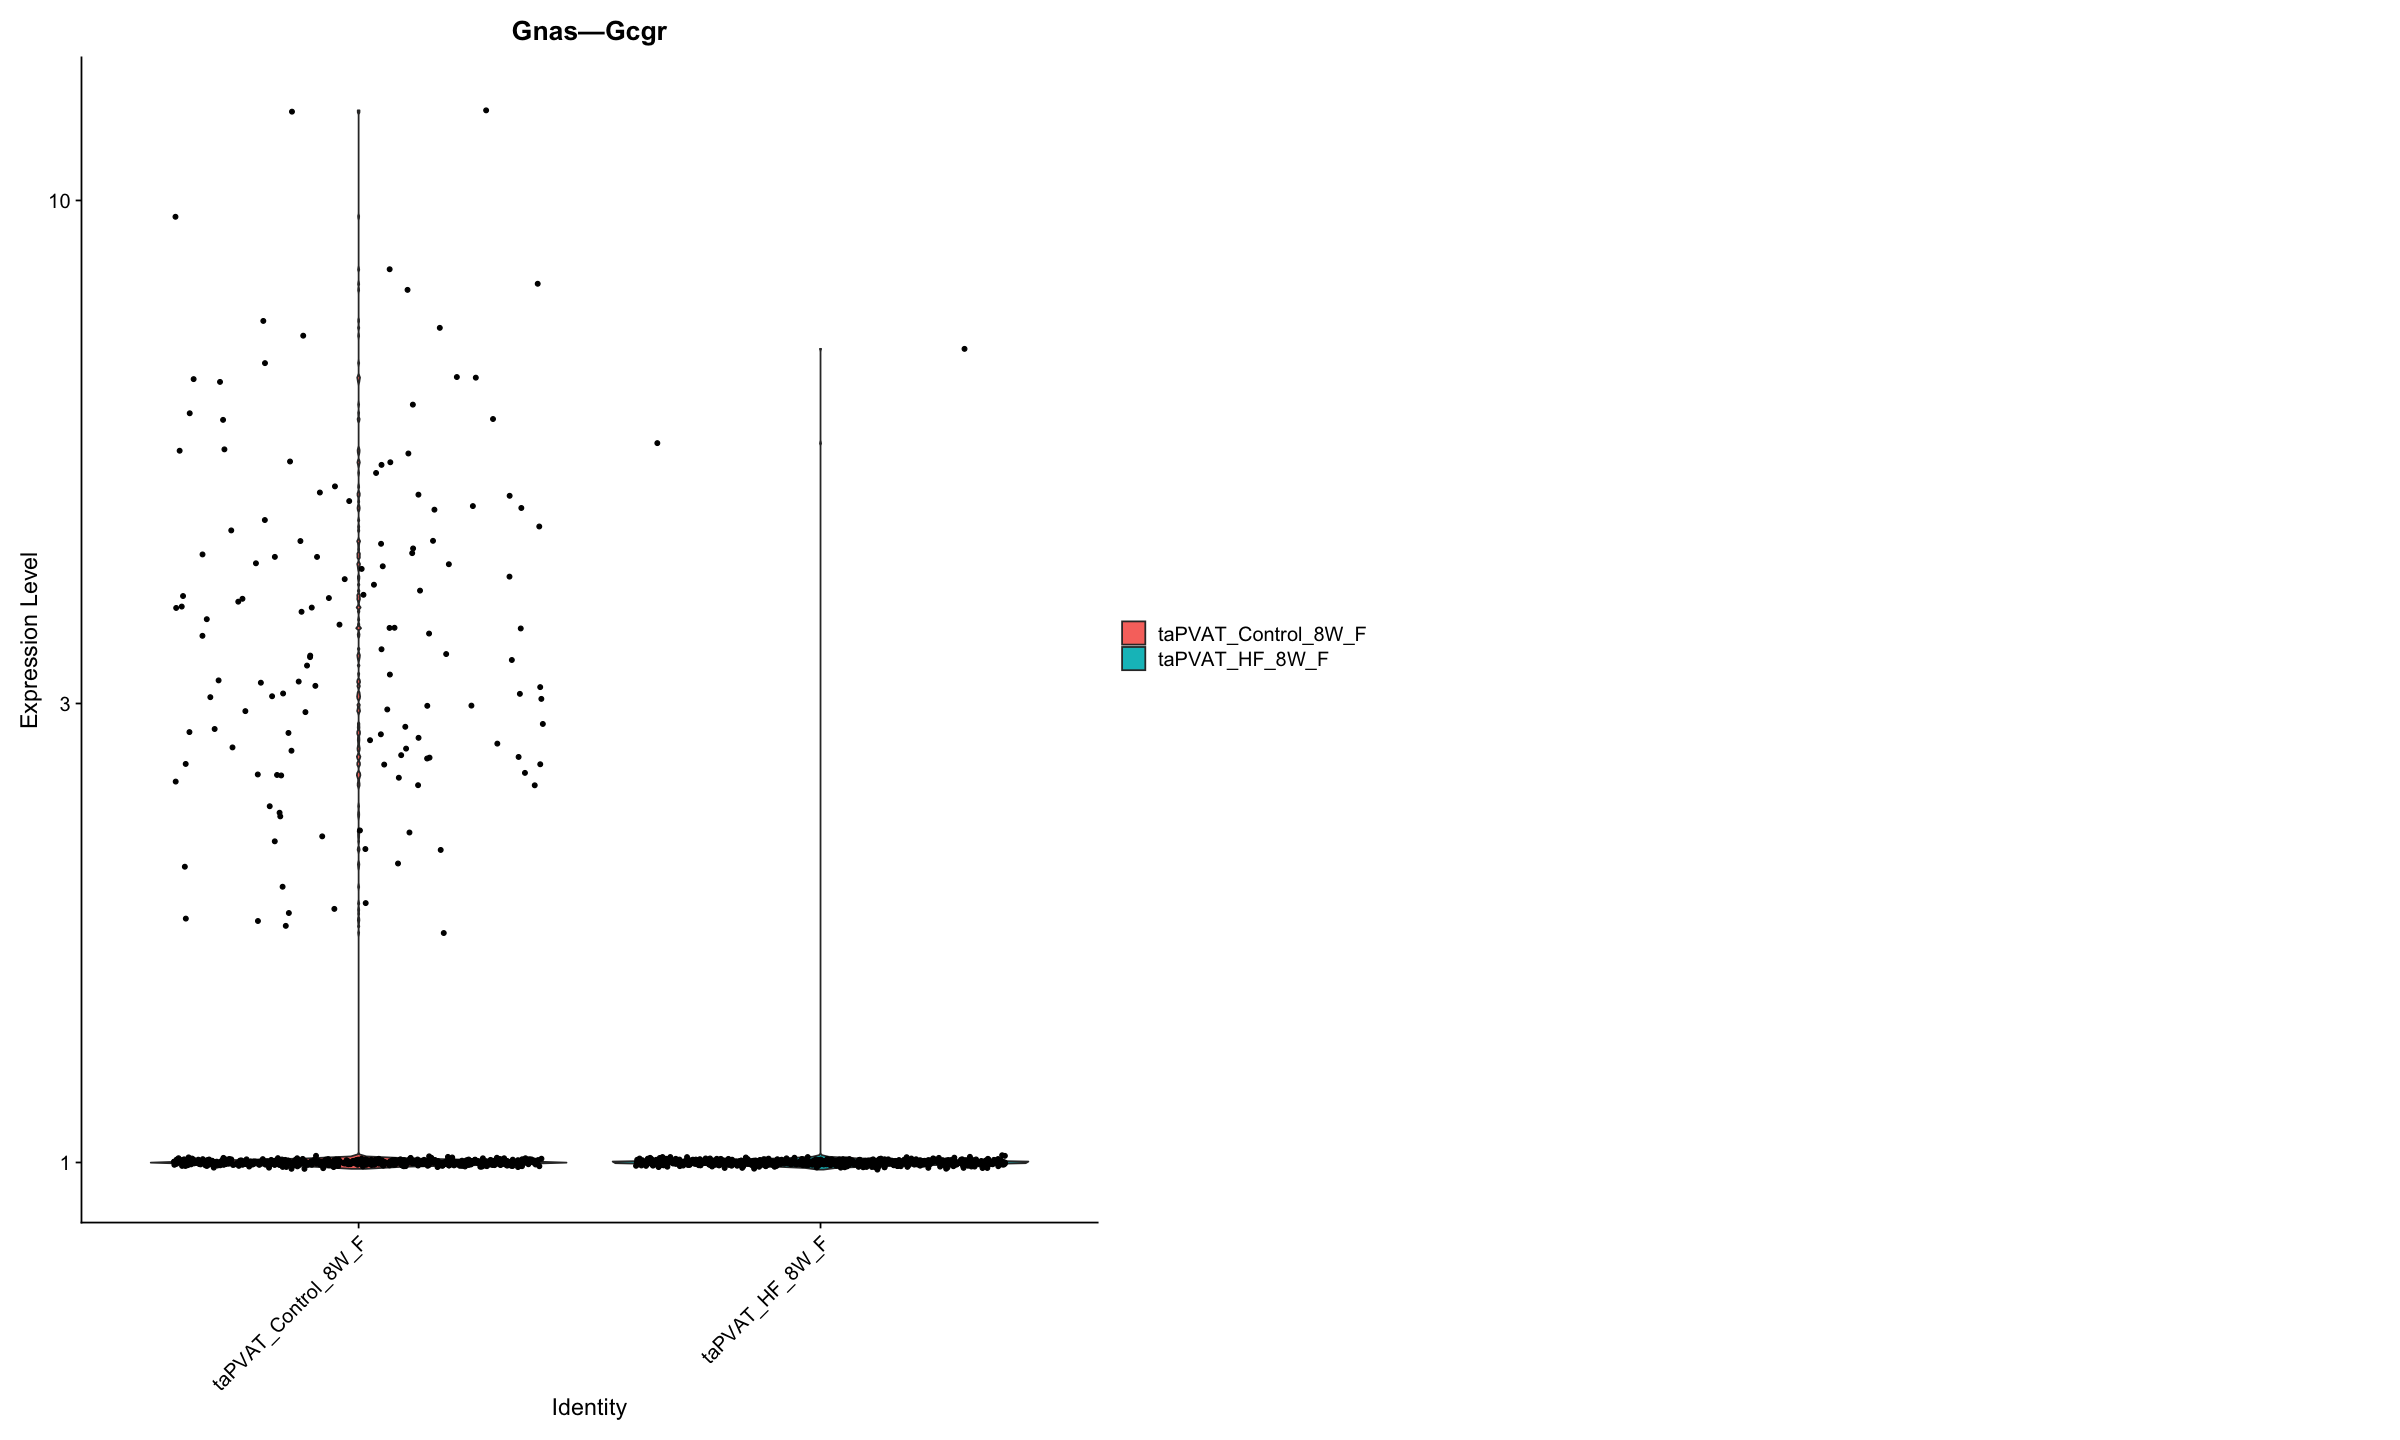

In [37]:
VlnPlot(voi.data,
            features = c('Gnas—Gcgr','Plau—Lrp1'),log = T,group.by = 'Condition')
